In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
from statistics import mean, median
from pandas import read_csv
import string
import xml.etree.ElementTree as et
from collections import Counter
import collections
import helper_functions

# Georgia 2020 Primary ERJ

This file builds off of the shapefiles found in VEST's 2020 Georgia election results file and adds in primary election data

## Election Results Documentation:

Election results from the Georgia Secretary of State Elections Division (https://sos.ga.gov/index.php/Elections/current_and_past_elections_results). Presidential recount results from the Georgia Secretary of State Elections Division via Reuters.

## Shapefile Source Documentation:

Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office (http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx).  
Cobb, DeKalb, and Gwinnett counties instead use shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program.  
Forsyth and Fulton use shapefiles sourced from the respective counties.

## Shapefile Modifications Documentation:

Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only reports one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

The following additional modifications reflect changes made prior to the 2020 general election.

Barrow: Merge 2/15, 3/12, 4/14, 5/7, 6/10/13, 8/9, 11/16; Adjust new 2/13 boundary  
Bartow: Split Cassville/Hamilton Crossing  
Candler: Merge Candler/Metter as Jack Strickland Comm Center  
Chatham: Split 7-7/8-16, 7-12/7-16; Realign 7-06C/7-07C  
Chatooga: Split Cloudland/Teloga along ridgeline that marks boundary between them with the USGS Topographic Contour shapefile  
Clayton: Split Ellenswood 1/2, Jonesboro 1/17/19, Lovejoy 3/6/7, Morrow 3/11, 5/10, Oak 3/5   
Cobb: Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B  
Columbia: Split Bessie Thomas/2nd Mt Moriah, Harlem Branch/Harlem Senior Ctr; Merge Blanchard Park/MTZ Col FD;  Align multiple precincts with county maps  
Coweta: Merge Arts Centre/Jefferson Parkway as Newnan Centre  
Fulton: Merge CP07A/CP07D, CH01/CH04B, SS29A/SS29B, UC031/UC035  
DeKalb: Split Clarkston/Clarkston Comm Ctr; Realign Decatur/Oakhurst; Align precincts with Atlanta, Brookhaven, Decatur, Tucker city limits   
Gwinnett: Adjust Baycreek F/G, Berkshire J/M, Cates D/F, Garners C/B, Lawrenceville G/N, Pinckneyville S/T, Rockbridge A/G  
Lowndes: Split Northgate Assembly/Trinity, Jaycee/Mt Calvary/Northside/VSU  
Oconee: Merge Annex/City Hall; Align City Hall with Watkinsville city limits  
Paulding: Reorganize 12 precincts into 19 precincts as redrawn in 2019  
Randolph: Merge Carnegie/Cuthbert-Courthouse, 4th District/Fountain Bridge/Shellman  
Troup: Split Mountville between Gardner Newman/Hogansville/Rosemont; Align multiple precincts with county maps  
Towns: Merge Macedonia/Tate City  
Wilkes: Align 1/2A boundary with the voter file    
Note that the leading zeros in the Paulding County precinct IDs are included in some election reports and omitted in others. The shapefile includes the leading zeros consistent with the voter file.

## Election Results Processing

### Load the VEST file

In [2]:
vest_ga_20 = gp.read_file("./raw-from-source/VEST/ga_2020/ga_2020.shp")
print(vest_ga_20.shape)

(2679, 50)


In [3]:
# Take a look
vest_ga_20.head(1)

#Create a list of the race columns
data_columns = [i for i in vest_ga_20.columns if (("20" in i) | ("21" in i))]
print(data_columns)

['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER', 'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA', 'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC', 'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN', 'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR', 'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL', 'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS', 'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA']


### 1. Load Election Results for August 11 Primary Runoff

This data had to be downloaded county-by-county in XML format. The below code parses the XML and grabs the necessary data, adds it to a list, gives it the appropriate column names, and converts the data into a dataframe.

In [4]:
loaded_counties = os.listdir("./raw-from-source/Election_Results/August_11_Primary/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Election_Results/August_11_Primary/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_general_1 = pd.DataFrame(z,columns=dfcols)

In [5]:
df_general_1["contest"] = df_general_1["contest"]+("-(08/11)")

### 2. Load Election Results for June 9 Primary

This data had to be downloaded county-by-county in XML format. The below code parses the XML and grabs the necessary data, adds it to a list, gives it the appropriate column names, and converts the data into a dataframe.

In [6]:
loaded_counties = os.listdir("./raw-from-source/Election_Results/June_9_Primary/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Election_Results/June_9_Primary/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_general_2 = pd.DataFrame(z,columns=dfcols)

In [7]:
# Make a note of the different primary dates
df_general_2["contest"] = df_general_2["contest"]+("-(06/09)")

In [8]:
# Make sure that the county and precinct names are the same across the two files
df_general_1["unique_ID_test"] = df_general_1["county"]+"-"+df_general_1["precinct"]
df_general_2["unique_ID_test"] = df_general_2["county"]+"-"+df_general_2["precinct"]

# for val in list(df_general_1["unique_ID_test"].unique()):
#     if val not in list(df_general_2["unique_ID_test"].unique()):
#         print(val)

In [9]:
# Combine the two files together
ga_election = pd.concat([df_general_1,df_general_2])

In [10]:
#Sanity check that there are the right number of counties
print(len(ga_election["county"].unique()))

159


### Filter Down to Relevant Contests

In [11]:
# Standardize the contest names
ga_election["contest"] = ga_election["contest"].str.strip()

contest_name_changes = {
 'REP - US House Dist 4/Distrito del Congreso 4-(06/09)':'REP - US House Dist 4-(06/09)',
 'DEM - US House Dist 4/Distrito del Congreso 4-(06/09)':'DEM - US House Dist 4-(06/09)',
 'REP - US House Dist 7/Distrito del Congreso 7-(06/09)':'REP - US House Dist 7-(06/09)',
 'DEM - US House Dist 7/Distrito del Congreso 7-(06/09)':'DEM - US House Dist 7-(06/09)',
 'REP - US House Dist 10/Distrito del Congreso 10-(06/09)':'REP - US House Dist 10-(06/09)',
 'DEM - US House Dist 10/Distrito del Congreso 10-(06/09)':'DEM - US House Dist 10-(06/09)',
 'DEM - State House Dist 81/Estatal ante la Asamblea General Dist 81-(06/09)':'DEM - State House Dist 81-(06/09)',
 'REP - State House Dist 93/Estatal ante la Asamblea General Dist 93-(06/09)':'REP - State House Dist 93-(06/09)',
 'DEM - State House Dist 93/Estatal ante la Asamblea General Dist 93-(06/09)':'DEM - State House Dist 93-(06/09)',
 'DEM - State House Dist 94/Estatal ante la Asamblea General Dist 94-(06/09)':'DEM - State House Dist 94-(06/09)',
 'REP - State House Dist 95/Estatal ante la Asamblea General Dist 95-(06/09)':'REP - State House Dist 95-(06/09)',
 'DEM - State House Dist 95/Estatal ante la Asamblea General Dist 95-(06/09)':'DEM - State House Dist 95-(06/09)',
 'DEM - State House Dist 96/Estatal ante la Asamblea General Dist 96-(06/09)':'DEM - State House Dist 96-(06/09)',
 'REP - State House Dist 97/Estatal ante la Asamblea General Dist 97-(06/09)':'REP - State House Dist 97-(06/09)',
 'DEM - State House Dist 97/Estatal ante la Asamblea General Dist 97-(06/09)':'DEM - State House Dist 97-(06/09)',
 'REP - State House Dist 98/Estatal ante la Asamblea General Dist 98-(06/09)':'REP - State House Dist 98-(06/09)',
 'DEM - State House Dist 98/Estatal ante la Asamblea General Dist 98-(06/09)':'DEM - State House Dist 98-(06/09)',
 'DEM - State House Dist 99/Estatal ante la Asamblea General Dist 99-(06/09)':'DEM - State House Dist 99-(06/09)',
 'DEM - State House Dist 100/Estatal ante la Asamblea General Dist 100-(06/09)':'DEM - State House Dist 100-(06/09)',
 'REP - State House Dist 101/Estatal ante la Asamblea General Dist 101-(06/09)':'REP - State House Dist 101-(06/09)',
 'DEM - State House Dist 101/Estatal ante la Asamblea General Dist 101-(06/09)':'DEM - State House Dist 101-(06/09)',
 'REP - State House Dist 102/Estatal ante la Asamblea General Dist 102-(06/09)':'REP - State House Dist 102-(06/09)',
 'DEM - State House Dist 102/Estatal ante la Asamblea General Dist 102-(06/09)':'DEM - State House Dist 102-(06/09)',
 'REP - State House Dist 103/Estatal ante la Asamblea General Dist 103-(06/09)':'REP - State House Dist 103-(06/09)',
 'DEM - State House Dist 103/Estatal ante la Asamblea General Dist 103-(06/09)':'DEM - State House Dist 103-(06/09)',
 'REP - State House Dist 104/Estatal ante la Asamblea General Dist 104-(06/09)':'REP - State House Dist 104-(06/09)',
 'DEM - State House Dist 104/Estatal ante la Asamblea General Dist 104-(06/09)':'DEM - State House Dist 104-(06/09)',
 'REP - State House Dist 105/Estatal ante la Asamblea General Dist 105-(06/09)':'REP - State House Dist 105-(06/09)',
 'DEM - State House Dist 105/Estatal ante la Asamblea General Dist 105-(06/09)':'DEM - State House Dist 105-(06/09)',
 'REP - State House Dist 106/Estatal ante la Asamblea General Dist 106-(06/09)':'REP - State House Dist 106-(06/09)',
 'DEM - State House Dist 106/Estatal ante la Asamblea General Dist 106-(06/09)':'DEM - State House Dist 106-(06/09)',
 'REP - State House Dist 107/Estatal ante la Asamblea General Dist 107-(06/09)':'REP - State House Dist 107-(06/09)',
 'DEM - State House Dist 107/Estatal ante la Asamblea General Dist 107-(06/09)':'DEM - State House Dist 107-(06/09)',
 'REP - State House Dist 108/Estatal ante la Asamblea General Dist 108-(06/09)':'REP - State House Dist 108-(06/09)',
 'DEM - State House Dist 108/Estatal ante la Asamblea General Dist 108-(06/09)':'DEM - State House Dist 108-(06/09)',
 'REP - State House Dist 114/Estatal ante la Asamblea General Dist 114-(06/09)':'REP - State House Dist 114-(06/09)',
 'DEM - State Senate Dist 5/Senador Estatal Dist 5-(06/09)':'DEM - State Senate Dist 5-(06/09)',
 'REP - State Senate Dist 40/Senador Estatal Dist 40-(06/09)':'REP - State Senate Dist 40-(06/09)',
 'DEM - State Senate Dist 40/Senador Estatal Dist 40-(06/09)':'DEM - State Senate Dist 40-(06/09)',
 'REP - State Senate Dist 41/Senador Estatal Dist 41-(06/09)':'REP - State Senate Dist 41-(06/09)',
 'DEM - State Senate Dist 41/Senador Estatal Dist 41-(06/09)':'DEM - State Senate Dist 41-(06/09)',
 'REP - State Senate Dist 45/Senador Estatal Dist 45-(06/09)':'REP - State Senate Dist 45-(06/09)',
 'DEM - State Senate Dist 45/Senador Estatal Dist 45-(06/09)':'DEM - State Senate Dist 45-(06/09)',
 'REP - State Senate Dist 48/Senador Estatal Dist 48-(06/09)':'REP - State Senate Dist 48-(06/09)',
 'DEM - State Senate Dist 48/Senador Estatal Dist 48-(06/09)':'DEM - State Senate Dist 48-(06/09)',
 'DEM - State Senate Dist 55/Senador Estatal Dist 55-(06/09)':'DEM - State Senate Dist 55-(06/09)',
 'REP - President of the United States/Presidentede los Estados Unidos-(06/09)':'REP - President of the United States-(06/09)',
 'DEM - President of the United States/Presidentede los Estados Unidos-(06/09)':'DEM - President of the United States-(06/09)',
 'REP - US Senate/Senado de los EE.UU.-(06/09)':'REP - US Senate-(06/09)',
 'DEM - US Senate/Senado de los EE.UU.-(06/09)':'DEM - US Senate-(06/09)',
 'REP - Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1-(06/09)':'REP - Public Service Commission Dist 1-(06/09)',
 'DEM - Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1-(06/09)':'DEM - Public Service Commission Dist 1-(06/09)',
 'REP - Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4-(06/09)':'REP - Public Service Commission Dist 4-(06/09)',
 'DEM - Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4-(06/09)':'DEM - Public Service Commission Dist 4-(06/09)',
}

ga_election["contest"] = ga_election["contest"].map(contest_name_changes).fillna(ga_election["contest"])
ga_election["contest"] = ga_election["contest"].str.replace("District", "Dist")

#### Look into contest names that don't have a party

In [12]:
ga_election["choice"] = ga_election["choice"].str.strip()
no_party = [i for i in list(ga_election["contest"].unique()) if "DEM -" not in i and "REP - " not in i]

# Looked on Ballotpedia to get the candidate's party
ga_election["contest"] = np.where(ga_election["choice"].isin(['Scott Bohlke', 'Billy Hickman', 'Kathy Palmer','Neil Singleton']), "REP - "+ga_election["contest"], ga_election["contest"])
ga_election["contest"] = np.where(ga_election["choice"].isin(['Stephen Jared Sammons']), "IND - "+ga_election["contest"], ga_election["contest"])

# All the remaining candidates w/o a party are ones we are not interested in
no_party = [i for i in list(ga_election["contest"].unique()) if "DEM -" not in i and "REP - " not in i and "IND -" not in i]

#### Grab the Different Races

In [13]:
total_races_list = list(ga_election["contest"].unique())

possible_us_house_races = [i for i in total_races_list if "US House" in i]
possible_ga_house_races = [i for i in total_races_list if "State House" in i]
possible_ga_senate_races = [i for i in total_races_list if "State Senate" in i]
possible_president_races = [i for i in total_races_list if "President of" in i]
possible_us_senate_races = [i for i in total_races_list if "US Senate" in i]
possible_possible_service_races = [i for i in total_races_list if "Public Service" in i]

# Make a list of all the above races
combined_races = possible_us_house_races + possible_ga_house_races + possible_ga_senate_races + possible_president_races +possible_us_senate_races + possible_possible_service_races

In [14]:
# # The code below looks at the races not included
# not_included_races = [i for i in total_races_list if i not in combined_races]
# not_included_races.sort()
# not_included_races

# Filter down to the needed races and clean indices
ga_election = ga_election[ga_election["contest"].isin(combined_races)]
ga_election.reset_index(inplace=True,drop=True)

### Clean and Pivot Data

In [15]:
ga_election["num_votes"] = ga_election["num_votes"].astype(int)

#ga_election["choice"] = ga_election["choice"].str.replace("Carden H. Summers", 'Carden H. Summers (I)') 
ga_election["choice"] = ga_election["choice"].str.replace("  ", ' ') 
ga_election["choice"] = ga_election["choice"].str.replace("Marcus A Wiedower", "Marcus A. Wiedower")

ga_election["choice"] = ga_election["choice"].map({'Carden H. Summers':'Carden H. Summers (I)'}).fillna(ga_election["choice"])

#### Add a FIPS Column

In [16]:
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Georgia"]
fips_file["FIPS County"] = fips_file["FIPS County"].astype(str)
fips_file["FIPS County"] = fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"] = fips_file["County Name"].replace("De Kalb","DeKalb")
fips_dict = dict(zip(fips_file['County Name'], fips_file['FIPS County']))
ga_election['county_fips'] = ga_election['county'].map(fips_dict).fillna(ga_election['county'])
ga_election['county_fips'] = ga_election['county_fips'].astype(str)
ga_election['county_fips'] = ga_election['county_fips'].str.zfill(3)

#### Pivot the data

In [17]:
ga_election["unique_ID"]=ga_election["county_fips"]+ga_election["precinct"]
ga_election["choice"]=ga_election["choice"]+"-:+:-"+ga_election["contest"]
ga_election=pd.pivot_table(ga_election,index=["unique_ID","county","county_fips","precinct"],columns=["choice"],values=['num_votes'],aggfunc=sum)
ga_election = ga_election.fillna(0)
ga_election.columns = ga_election.columns.droplevel(0)
ga_election = ga_election.reset_index()

### Clean Column Names

In [18]:
possible_us_house_races = [i for i in total_races_list if "US House" in i]
possible_ga_house_races = [i for i in total_races_list if "State House" in i]
possible_ga_senate_races = [i for i in total_races_list if "State Senate" in i]
possible_president_races = [i for i in total_races_list if "President of" in i]
possible_us_senate_races = [i for i in total_races_list if "US Senate" in i]
possible_possible_service_races = [i for i in total_races_list if "Public Service" in i]

In [19]:
def get_race(race_string):
    race_string = race_string.split("-:+:-")[1]
    if "US House" in race_string:
        return "CON"
    elif "State House" in race_string:
        return "SL"
    elif "State Senate" in race_string:
        return "SU"
    elif "President of" in race_string:
        return "PRE"
    elif "US Senate" in race_string:
        return "USS"
    elif "Public Service" in race_string:
        return "PSC"
    else:
        print("No race for:", race_string)
        raise ValueError
        
def get_election_type(race_string):
    race_string = race_string.split("-:+:-")[1]
    if "Special" in race_string and "(08/11)" in race_string:
        return "SR"
    elif "Special" in race_string:
        return "S"  
    elif "(08/11)" in race_string:
        return "R"
    elif "(06/09)" in race_string:
        return "P"
    else:
        print("No electiont type for:", race_string)
        raise ValueError
        
def get_party(race_string):
    race_string = race_string.split("-:+:-")[1]
    if "REP - " in race_string:
        return "R"
    elif "DEM - " in race_string:
        return "D"
    elif "IND - " in race_string:
        return "I"
    else:
        print("No party for:", race_string)
        raise ValueError    
        
def get_name(name_string):
    name_string = name_string.split("-:+:-")[0]
    name_string = name_string.replace(" (I)","")
    name_string = name_string.replace("'","")
    likely_last = name_string.split(" ")[-1]
    proposed_last = likely_last[:3]
    if proposed_last in ['II', 'III', 'Jr', 'Jr.', 'Sr.']:
        likely_last = name_string.split(" ")[-2]
        proposed_last = likely_last[:3]
    return proposed_last.upper()

def get_district(race_string, fill_level):
    race_string = race_string.split("-:+:-")[1]
    if "Special - State Senate Dist" in race_string:
        return "04"
    else:
        dist_area = race_string.split("-")[1]
        dist = dist_area.split(" ")[-1]
        if dist.zfill(fill_level) == "00":
            return "04"
        else:
            return dist.zfill(fill_level)

def column_rename_function(name_string):
    election_type = get_election_type(name_string)
    year = "20"
    party = get_party(name_string)
    race = get_race(name_string)
    district = ""
    if race in ["CON", "SU"]:
        district = get_district(name_string, 2)
        year = ""
    elif race in ["SL"]:
        district = get_district(name_string, 3)
        year = ""
    name = get_name(name_string)
    new_col_name = election_type + year + race + district + party + name
    if len(new_col_name) > 10:
        print(name_string)
        print(new_col_name)
    return new_col_name

In [20]:
race_columns = [i for i in ga_election.columns if i not in ['unique_ID', 'county', 'county_fips', 'precinct']]

race_updates_dict = {}

for val in race_columns:
    race_updates_dict[val] = column_rename_function(val)

### Create Fields Dictionaries

In [90]:
# This dictionary was used to check against the county totals
od = collections.OrderedDict(sorted(race_updates_dict.items()))
fields_dict_lower_df_full = pd.DataFrame.from_dict(od, orient ='index')
fields_dict_lower_df_full.reset_index(inplace = True, drop = False)
fields_dict_lower_df_full.columns = ['Field_Name', 'Cand_Name']
fields_dict_lower_df_full.to_csv("./primary_fields_dict_full.csv", index = False)

In [91]:
# This dictionary was used in the README
fields_dict_lower = {race_updates_dict[i]:i.split("-:+:-")[0] for i in race_updates_dict.keys()}
od = collections.OrderedDict(sorted(fields_dict_lower.items()))
fields_dict_lower_df = pd.DataFrame.from_dict(od, orient ='index')
fields_dict_lower_df.reset_index(inplace = True, drop = False)
fields_dict_lower_df.columns = ['Field_Name', 'Cand_Name']
fields_dict_lower_df.to_csv("./primary_fields_dict.csv", index = False)

## Rename Columns and Further Cleaning

In [23]:
ga_election.rename(columns = race_updates_dict, inplace = True)
all_data_columns = [i for i in ga_election.columns if i not in ['unique_ID', 'county', 'county_fips', 'precinct']]
all_data_columns.sort()
ga_election = ga_election[['unique_ID', 'county', 'county_fips', 'precinct']+all_data_columns]

for val in all_data_columns:
    ga_election[val] = ga_election[val].astype(int)

## Load U.S. Congress, State Senate and State House Files

In [24]:
# Load congress
ga_cong_districts = gp.read_file("./raw-from-source/US_House_Shapefile/ga_cong_2011_to_2021/ga_cong_2011_to_2021.shp")
ga_cong_districts = ga_cong_districts.to_crs(vest_ga_20.crs)
ga_cong_districts.rename(columns={'DISTRICT':"CONG_DISTRICT"},inplace=True)
ga_cong_districts["CONG_DISTRICT"] = ga_cong_districts["CONG_DISTRICT"].str[1:3]
ga_cong_districts["geometry"] = ga_cong_districts["geometry"].buffer(0)

# Load state upper
ga_sldu_districts = gp.read_file("./raw-from-source/SLDU_Districts/ga_sldu_2014_to_2021/ga_sldu_2014_to_2021.shp")
ga_sldu_districts = ga_sldu_districts.to_crs(vest_ga_20.crs)
ga_sldu_districts.rename(columns={'DISTRICT':"SLDU_DISTRICT"},inplace=True)
ga_sldu_districts["SLDU_DISTRICT"] = ga_sldu_districts["SLDU_DISTRICT"].str[1:3]

# Load state lower
ga_sldl_districts = gp.read_file("./raw-from-source/SLDL_Districts/ga_sldl_2015_to_2021/ga_sldl_2015_to_2021.shp")
ga_sldl_districts = ga_sldl_districts.to_crs(vest_ga_20.crs)
ga_sldl_districts.rename(columns={'DISTRICT':"SLDL_DISTRICT"},inplace=True)

## Look into Bibb County Differences

Note: This was a change we made in the general election file, want to make sure it also applies here

In [25]:
# Filter out the Bibb portion of VEST's shapefile
vest_bibb = vest_ga_20[vest_ga_20["FIPS2"]=="021"]

# Get the remaining piece of VEST's shapefile
vest_no_bibb = vest_ga_20[vest_ga_20["FIPS2"]!="021"]
vest_no_bibb.reset_index(inplace = True, drop = True)

# Load in Bibb's shape
bibb_county_shp = gp.read_file("./raw-from-source/Shapefiles/Bibb/Voting_Precinct-shp/Voting_Precinct.shp")
bibb_county_shp = bibb_county_shp.to_crs(vest_ga_20.crs)

Checking 31 precincts for differences of greater than 0.1 km^2

1) For HOWARD 5 difference in area is 0.49782923694484243
2) For HOWARD 3 difference in area is 1.5507978496113173
3) For HOWARD 1 difference in area is 5.004606007458073
4) For HAZZARD 4 difference in area is 3.3709531904547556
5) For HOWARD 7 difference in area is 0.10943615786443162
6) For HOWARD 2 difference in area is 2.5757633631168155

Scroll down to see plots of any differences

Of the 31 precincts:

0 precincts w/ a difference of 0 km^2
25 precincts w/ a difference between 0 and .1 km^2
2 precincts w/ a difference between .1 and .5 km^2
0 precincts w/ a difference between .5 and 1 km^2
1 precincts w/ a difference between 1 and 2 km^2
2 precincts w/ a difference between 2 and 5 km^2
1 precincts w/ a difference greater than 5 km^2


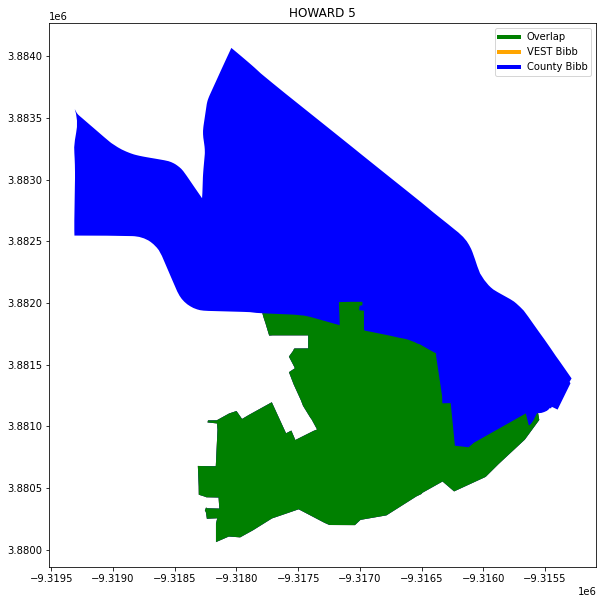

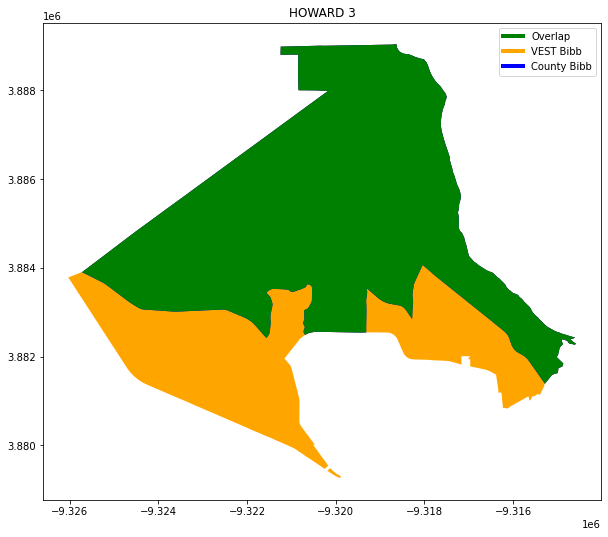

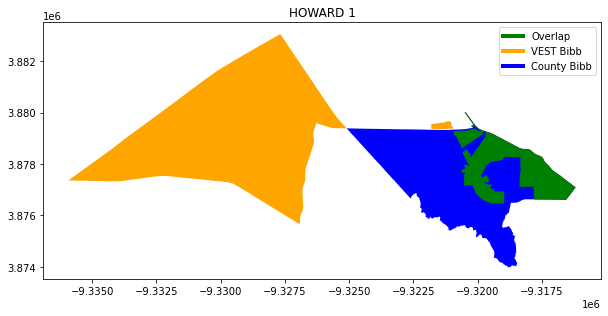

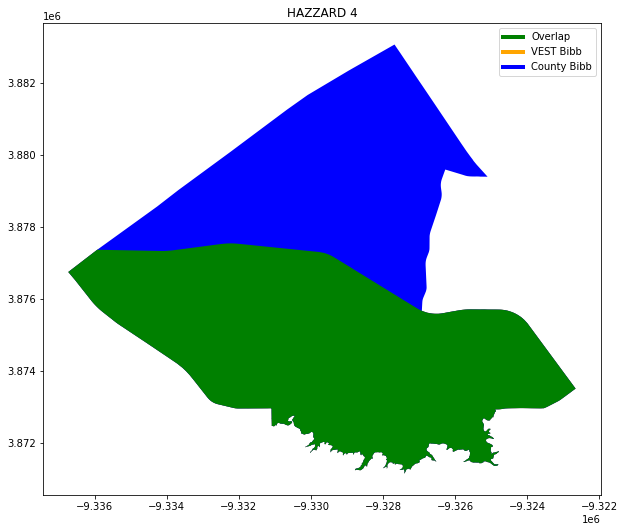

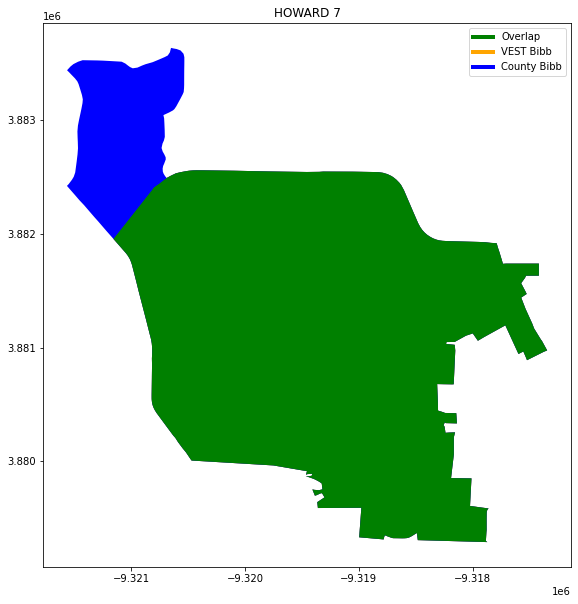

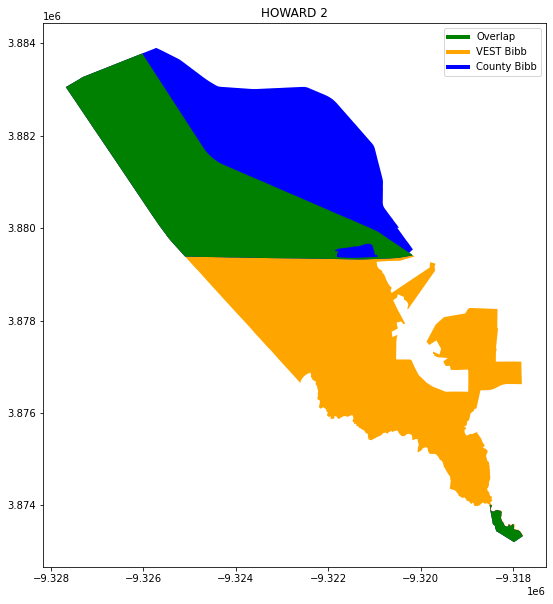

In [26]:
bibb_county_shp["PRECINCT_N"] = bibb_county_shp["NAME"]

helper_functions.compare_geometries(vest_bibb, bibb_county_shp, "VEST Bibb", "County Bibb", "PRECINCT_N", "precincts")

### From the above, we see there are differences in the following precincts:
Howard 1, Howard 2, Howard 3, Howard 5, Howard 7, Hazzard 4

In [27]:
#bibb_diff_precs = ["Howard 1", "Howard 2", "Howard 3", "Howard 5", "Howard 7", "Hazzard 4"]
bibb_diff_precs = ["Howard 3", "Howard 1"]
#bibb_diff_precs_shps = ["HOWARD 1", "HOWARD 2", "HOWARD 3", "HOWARD 5", "HOWARD 7", "HAZZARD 4"]
bibb_diff_precs_shps = ["HOWARD 3", "HOWARD 1"]

ga_election[ga_election["precinct"].isin(bibb_diff_precs)][[i for i in ga_election.columns if "PSU25" in i or "PSU18" in i]+["unique_ID"]]

choice,PSU18RKEN,PSU25DBRI,PSU25RJON,unique_ID
91,725,0,0,021Howard 1
93,310,842,278,021Howard 3


<AxesSubplot:>

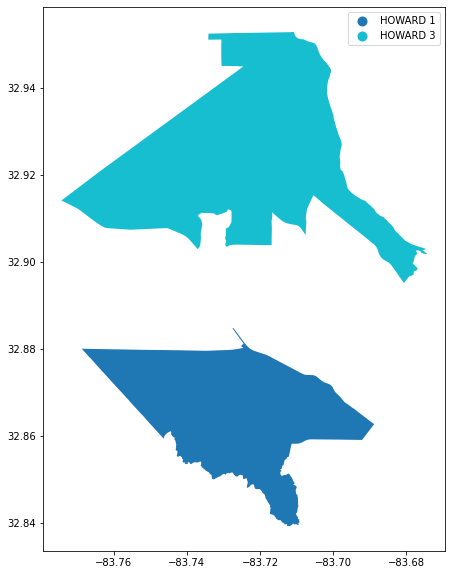

In [28]:
bibb_county_shp[bibb_county_shp["PRECINCT_N"].isin(bibb_diff_precs_shps)].plot(figsize = (10,10), column = "PRECINCT_N", legend = True)

<AxesSubplot:>

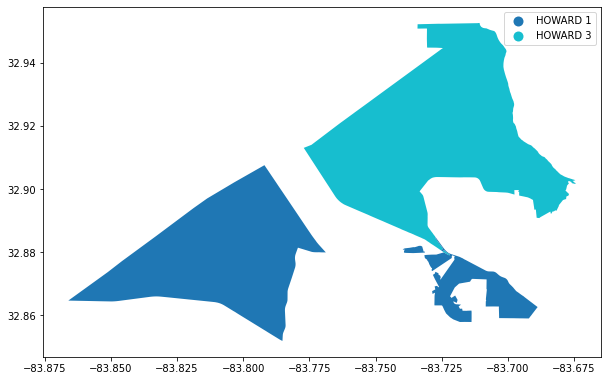

In [29]:
vest_bibb[vest_bibb["PRECINCT_N"].isin(bibb_diff_precs_shps)].plot(figsize = (10,10), column = "PRECINCT_N", legend = True)

In [30]:
# Create the join column in the Bibb County shapefile
bibb_county_shp["DISTRICT"] = "021"+bibb_county_shp["POLLINGID"]

joined_bibb = pd.merge(bibb_county_shp, vest_bibb, how = "outer", on = "DISTRICT", indicator = True)

# Note the values join cleanly
print(joined_bibb["_merge"].value_counts())

joined_bibb.drop(["_merge", "geometry_y"], axis = 1, inplace = True)

joined_bibb.rename(columns = {'geometry_x':'geometry', "PRECINCT_N_x":'PRECINCT_N'}, inplace = True)

joined_bibb = gp.GeoDataFrame(joined_bibb, crs = vest_ga_20.crs)
joined_bibb = joined_bibb[list(vest_ga_20.columns)]

vest_ga_20 = gp.GeoDataFrame(pd.concat([joined_bibb, vest_no_bibb]), crs = vest_ga_20.crs)
vest_ga_20.reset_index(inplace = True, drop = True)

both          31
left_only      0
right_only     0
Name: _merge, dtype: int64


## Join Election Results to Precincts

#### Try a  unique ID

In [31]:
ga_election["precinct"] = ga_election["precinct"].str.strip().str.upper()
ga_election["unique_ID"]=ga_election["county_fips"]+"-"+ga_election["precinct"]
vest_ga_20["unique_ID"]=vest_ga_20["FIPS2"]+"-"+vest_ga_20["PRECINCT_N"]

#### Check whether there are duplicate IDs

In [32]:
ser = ga_election["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

ser = vest_ga_20["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

Series([], Name: unique_ID, dtype: int64)
NaN                        7
051-ELI WHITNEY COMPLEX    2
Name: unique_ID, dtype: int64


In [33]:
#Look into duplicate IDs - ELI WHITNEY
display(vest_ga_20[vest_ga_20["unique_ID"]=="051-ELI WHITNEY COMPLEX"])

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,G20PSCDBLA,G20PSCLWIL,R21USSRPER,R21USSDOSS,R21USSRLOE,R21USSDWAR,R21PSCRMCD,R21PSCDBLA,geometry,unique_ID
2261,0513-15C,0513-15C,3-15C,ELI WHITNEY COMPLEX,CHATHAM,25,025,051,278,361,...,325,15,281,329,282,329,284,318,"POLYGON ((-81.02948 32.06200, -81.03000 32.060...",051-ELI WHITNEY COMPLEX
2263,0512-06C,0512-06C,2-06C,ELI WHITNEY COMPLEX,CHATHAM,25,025,051,65,335,...,301,19,52,312,53,311,54,300,"POLYGON ((-81.05333 32.07291, -81.05336 32.072...",051-ELI WHITNEY COMPLEX


In [34]:
#Assign new unique IDs, adding in PRECINCT_I to differentiate
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0513-15C","unique_ID"] = "051-ELI WHITNEY COMPLEX 3-15C"
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0512-06C","unique_ID"] = "051-ELI WHITNEY COMPLEX 2-06C"

# For the others, set the unique_ID to the DISTRICT
vest_ga_20.loc[vest_ga_20['unique_ID'].isna(), 'unique_ID'] = vest_ga_20['DISTRICT']

#### Confirm there are no more duplicate IDs

In [35]:
ser = ga_election["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

ser = vest_ga_20["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

Series([], Name: unique_ID, dtype: int64)
Series([], Name: unique_ID, dtype: int64)


In [36]:
#First join attempt
join_attempt_1 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_1["_merge"].value_counts())

left_only = join_attempt_1[join_attempt_1["_merge"]=="left_only"]
right_only = join_attempt_1[join_attempt_1["_merge"]=="right_only"]

both          2492
right_only     187
left_only      135
Name: _merge, dtype: int64


In [37]:
# Note the below use either "DISTRCT" or the "unique_ID" value
erj_match_increaser_dict = {
  '053-ACTIVITY CENTER': '053-ACTIVITY CENTER (Includes FTBEN 1-3)',
 '067-POWDERS SPRINGS 1A': '067-POWDER SPRINGS 1A',
 '067-POWDERS SPRINGS 2A': '067-POWDER SPRINGS 2A',
 '067-POWDERS SPRINGS 3A': '067-POWDER SPRINGS 3A',
 '171-CHAPPELL MILL V FD': '171-CHAPPELL MILL VFD',
 '275-LITTLE OCHLOCKNEE BAPTIST CHURCH': '275-LITTLE OCHLOCKNEE',
 '299-100': '299-District 1',
 '299-200A': '299-District 2A',
 '299-200B': '299-District 2B',
 '299-300': '299-1231-150B',
 '299-304': '299-1231-150C',
 '299-400': '299-1231-151',
 '299-404': '299-Beach-Bickley',
 '299-405': '299-Haywood',
 '299-406': '299-Jamestown',
 '299-407': '299-Manor',
 '299-408': '299-Millwood',
 '299-409': '299-Waresboro',
 '317-TIGNAL SCH LUNCH RM': '317-TIGNALL SCH LUNCH RM',  
    '051-3-05 ALDERSGATE YOUTH CENTER': '051-ALDERSGATE YOUTH CENTER',
 '051-6-11 BAMBOO FARMS': '051-BAMBOO FARMS',
 '051-5-01 BARTLETT MIDDLE SCHOOL': '051-BARTLETT MIDDLE SCHOOL',
 '051-8-12 BEACH HIGH SCHOOL': '051-BEACH HIGH SCHOOL',
 '051-3-10 BIBLE BAPTIST CHURCH': '051-BIBLE BAPTIST CHURCH',
 '051-2-02 BLACKSHEAR COMMUNITY CENTER': '051-BLACKSHEAR COMMUNITY CENTER',
 '051-7-08 BLOOMINGDALE COMM CTR': '051-BLOOMINGDALE COMM CTR',
 '051-8-11 BUTLER ELEMENTARY': '051-BUTLER ELEMENTARY',
 '051-5-03 BUTLER PRESBYTERIAN CHURCH': '051-BUTLER PRESBYTERIAN CHURCH',
 '051-8-10 CARVER HEIGHTS COMM CTR': '051-CARVER HEIGHTS COMM CTR',
 '051-1-06 CENTRAL CHURCH OF CHRIST': '051-CENTRAL CHURCH OF CHRIST',
 '051-2-07 CHRIST COMMUNITY CHURCH': '051-CHRIST COMMUNITY CHURCH',
 '051-8-01 CIVIC CENTER': '051-CIVIC CENTER',
 '051-7-14 COASTAL CATHEDRAL': '051-COASTAL CATHEDRAL',
 '051-3-09 COKESBURY METHODIST': '051-COKESBURY METHODIST',
 '051-1-14 ST LUKE CHURCH': '051-COMPASSION CHRISTIAN CHURCH',
 '051-6-03 CRUSADER COMM CENTER': '051-CRUSADER COMM CENTER',
 '051-3-15 ELI WHITNEY COMPLEX': '051-ELI WHITNEY COMPLEX 3-15C',
 '051-2-06 ELI WHITNEY COMPLEX': '051-ELI WHITNEY COMPLEX 2-06C',
 '051-5-07 ELKS LODGE': '051-ELKS LODGE',
 '051-2-04 FELLOWSHIP OF LOVE CHURCH': '051-FELLOWSHIP OF LOVE CHURCH',
 '051-1-16 FERGUSON AVE BAPTIST': '051-FERGUSON AVE BAPTIST',
 '051-3-04 FIRST AFRICAN BAPTIST CHURCH': '051-FIRST AFRICAN BAPTIST CHURCH',
 '051-4-06 FIRST BAPTIST OF THE ISLAND': '051-FIRST BAPTIST OF THE ISLAND',
 '051-1-01 FIRST PRESBYTERIAN CHURCH': '051-FIRST PRESBYTERIAN CHURCH',
 '051-4-02 FRANK MURRAY COMM CENTER': '051-FRANK MURRAY COMM CENTER',
 '051-8-15 GARDEN CITY BAPTIST': '051-GARDEN CITY REC CENTER',
 '051-7-01 GARDEN CITY SENIOR CTR': '051-GARDEN CITY SENIOR CTR',
 '051-6-10 GEORGETOWN ELEMENTARY': '051-GEORGETOWN ELEMENTARY',
 '051-1-08 GRACE UNITED METHODIST CHURCH': '051-GRACE UNITED METHODIST CHURCH',
 '051-4-10 TYBEE COURT HOUSE': '051-GUARD HOUSE COMM CTR',
 '051-8-02 HELLENIC CENTER': '051-HELLENIC CENTER',
 '051-2-05 HOLY SPIRIT LUTHERAN CHURCH': '051-HOLY SPIRIT LUTHERAN CHURCH',
 '051-1-09 IMMANUEL BAPTIST CHURCH': '051-IMMANUEL BAPTIST CHURCH',
 '051-1-17 ISLANDS CHRISTIAN CHURCH': '051-ISLANDS CHRISTIAN CHURCH',
 '051-1-12 ISLE OF HOPE BAPTIST': '051-ISLE OF HOPE BAPTIST',
 '051-1-05 JEA BUILDING': '051-JEA BUILDING',
 '051-3-08 JENKINS HIGH SCHOOL': '051-JENKINS HIGH SCHOOL',
 '051-7-04 LAKE SHORE COMM CTR': '051-LAKE SHORE COMM CTR',
 '051-5-11 LARGO-TIBET ELEMENTARY': '051-LARGO-TIBET ELEMENTARY',
 '051-5-05 LIBERTY CITY COMM CTR': '051-LIBERTY CITY COMM CTR',
 '051-4-04 LIGHTHOUSE BAPTIST CHURCH': '051-LIGHTHOUSE BAPTIST CHURCH',
 '051-8-09 MOSES JACKSON CENTER': '051-MOSES JACKSON CENTER',
 '051-3-13 NEW COV 7 DAY ADV CH': '051-NEW COV 7 DAY ADV CH',
 '051-3-14 OGLETHORPE CHARTER ACADEMY': '051-OGLETHORPE CHARTER ACADEMY',
 '051-3-01 OLD COURTHOUSE': '051-OLD COURTHOUSE',
 '051-7-03 PB EDWARDS GYM': '051-PB EDWARDS GYM',
 '051-7-12 POOLER CHURCH': '051-POOLER CHURCH',
 '051-7-06 POOLER CITY HALL': '051-POOLER CITY HALL',
 '051-7-10 PROGRESSIVE REC CENTER': '051-PROGRESSIVE REC CENTER',
 '051-8-08 RESUR OF OUR LORD CHURCH': '051-RESURRECTION OF OUR LORD CHURCH',
 '051-7-15 RICE CREEK SCHOOL': '051-RICE CREEK SCHOOL',
 '051-7-07 ROTHWELL BAPTIST CHURCH': '051-ROTHWELL BAPTIST CHURCH',
 '051-2-09 SALVATION ARMY': '051-SALVATION ARMY',
 '051-8-13 SAVANNAH CHRISTIAN': '051-SAVANNAH CHRISTIAN',
 '051-3-03 SAVANNAH HIGH SCHOOL': '051-SAVANNAH HIGH SCHOOL',
 '051-7-09 SAVANNAH HOLY C OF G': '051-SAVANNAH HOLY C OF G',
 '051-5-08 SAVANNAH PRIMITIVE BC': '051-SAVANNAH PRIMITIVE BC',
 '051-5-06 SEED CHURCH': '051-SEED CHURCH',
 '051-5-02 SENIOR CITIZENS CENTER': '051-SENIOR CITIZENS CENTER',
 '051-7-11 SEVENTH DAY ADV CHURCH': '051-SEVENTH DAY ADV CHURCH',
 '051-8-03 SILK HOPE BAPTIST CHURCH': '051-SILK HOPE BAPTIST CHURCH',
 '051-7-16 SHEPHERD LIVING': '051-POOLER REC CENTER GYM',
 '051-4-14 SKIDAWAY ISLAND METHODIST': '051-SKIDAWAY ISLAND BAPTIST',
 '051-4-13 SKIDAWAY ISLAND PRES CHURCH': '051-SKIDAWAY ISLAND PRES CHURCH',
 '051-4-15 SKIDAWAY ISLAND STATE PARK': '051-SKIDAWAY ISLAND STATE PARK',
 '051-3-11 SOUTHSIDE BAPTIST CHURCH': '051-SOUTHSIDE BAPTIST CHURCH',
 '051-7-13 SOUTHSIDE FIRE TRNG CTR': '051-SOUTHSIDE FIRE TRNG CTR',
 '051-4-05 ST FRANCIS EPISCOPAL CHURCH': '051-ST FRANCIS EPISCOPAL CHURCH',
 '051-4-12 ST PETERS EPISCOPAL': '051-ST PETERS EPISCOPAL',
 '051-1-10 ST THOMAS EPISCOPAL CHURCH': '051-ST THOMAS EPISCOPAL CHURCH',
 '051-2-11 STILLWELL TOWERS': '051-STILLWELL TOWERS',
 '051-5-10 JONESVILLE BAPTIST CHURCH': '051-TATUMVILLE COMMUNITY CENTER',
 '051-3-02 ROSE OF SHARON': '051-TEMPLE MICKVE ISRAEL',
 '051-6-06 THE LIGHT CHURCH': '051-THE LIGHT CHURCH',
 '051-1-13 THE SANCTUARY': '051-THE SANCTUARY',
 '051-3-12 THUNDERBOLT MUNI COMPLEX': '051-THUNDERBOLT MUNI COMPLEX',
 '051-8-06 TOMPKINS REC CENTER': '051-TOMPKINS REC CENTER',
 '051-6-09 TRINITY LUTHERAN CHURCH': '051-TRINITY LUTHERAN CHURCH',
 '051-4-11 TYBEE ISLAND SCHOOL CAFE': '051-TYBEE ISLAND SCHOOL CAFE',
 '051-6-08 SAVANNAH COMMONS': '051-CHRIST MEMORIAL BAPTIST CHURCH',
 '051-8-05 W BROAD ST YMCA': '051-W BROAD ST YMCA',
 '051-2-03 W W LAW CENTER': '051-W W LAW CENTER',
 '051-6-01 WHITE BLUFF PRESBYTERIAN': '051-WHITE BLUFF PRESBYTERIAN',
 '051-2-12 WILLIAMS COURT APTS': '051-WILLIAMS COURT APTS',
 '051-4-08 WILMINGTON ISLAND PRES CHURCH': '051-WILMINGTON ISLAND PRES CHURCH',
 '051-4-07 WILMINGTON ISLAND UMC': '051-WILMINGTON ISLAND UMC',
 '051-6-02 WINDSOR FOREST BAPTIST': '051-WINDSOR FOREST BAPTIST',
 '051-6-05 WINDSOR HALL': '051-WINDSOR HALL',
 '051-7-05 WOODLAWN BAPTIST CHURCH': '051-WOODLAWN BAPTIST CHURCH',
 '051-8-07 WOODVILLE-TOMPKINS TI': '051-WOODVILLE-TOMPKINS TI',
 '051-8-16 OAKS AT POOLER': '051-ROYAL CINEMAS AND IMAX',
 '087-COLISEUM': '087-BAINBRIDGE-COLISEUM',
 '087-FAIRGROUNDS': '087-BDGE-FAIRGROUNDS',
 '159-MARTIN & BURNEY': '159-MARTIN-BURNEY',
 '175-FIRE DEPT STA #5': '175-FIRE DEPT STA 5',
 '175-LCFS #10 (VALAMBROSIA)': '175-LCFS 10 VALAMBROSIA',
 '175-RURAL FIRE STA #17': '175-RURAL FIRE STA 17',
 '175-W T ADAMS FIRE STA #18': '175-W T ADAMS FIRE STA 18',
 '223-RUSSOM ELEM SCHOOL': '223-RUSSOM ELEMENTARY',
 '223-SHELTON ELEM SCHOOL': '223-SHELTON ELEMENTARY',
 '229-HACKLEBARNEY/CASON': '229-HACKLEBARNEY-CASON',
 '229-ST JOHNS/BLACKSHEAR': '229-ST JOHNS-BLACKSHEAR',
 '229-SUNSET/SWEAT': '229-SUNSET-SWEAT',
 '243-CUTHBERT/COURTHOUSE': '243-CUTHBERT-COURTHOUSE',
 '261-AG CENTER': '261-AGRI-CENTER',
 '261-REES PARK': '261-REESE PARK',
 '261-THOMSON': '261-THOMPSON',
 '275-MERRILVILLE': '275-MERRILLVILLE',
                           
### Note, there's only 1 precinct in Stephens
 '257-STEPHENS':'257-SENIOR CENTER',
                            
### https://www.walb.com/2020/10/26/lee-co-voting-precinct-gets-location-change/
### Article about a polling place location change in GA
 '177-SOVEREIGN GRACE':'177-FLINT REFORMED BAPTIST',
                   
### Article about how the Claiborne was the polling location for 105 https://www.columbiacountyga.gov/Home/ShowDocument?id=16129
 '073-THE CLAIBORNE AT WEST LAKE':'073-SAVANNAH RAPIDS PAVILION',
                            
### Past example (from 2017) of moving the location from EMC to Burson Center
 '045-EMC': '045-BURSON CENTER', 
                            
### Article laying out Oconee precicnt changes http://www.oconeecountyobservations.org/2020/09/new-voting-locations-reviewed-at-oconee.html
 '219-ATHENS ACADEMY':'219-EAST OCONEE',
 '219-NORTH HIGH SHOALS':'219-HIGH SHOALS',                          
}

In [38]:
#Apply the changes
ga_election["unique_ID"] = ga_election["unique_ID"].map(erj_match_increaser_dict).fillna(ga_election["unique_ID"])

In [39]:
#Third join attempt
join_attempt_3 = pd.merge(vest_ga_20,ga_election,how="outer",on="unique_ID",indicator=True)
print(join_attempt_3["_merge"].value_counts())

both = join_attempt_3[join_attempt_3["_merge"]=="both"]
left_only = join_attempt_3[join_attempt_3["_merge"]=="left_only"]
right_only = join_attempt_3[join_attempt_3["_merge"]=="right_only"]

both          2626
left_only       53
right_only       1
Name: _merge, dtype: int64


## Make remaining changes

Note: These changes were needed in Clayton, Fulton, Bartow, Cobb and Lowndes Counties

## Clayton

For Clayton, the primary votes were reported on names that matched those of the 2018 shapefile, so we used that instead.

In [40]:
ga_18_shps = gp.read_file("./raw-from-source/Old_Shapes/vtd2018-shapefile/VTD2018-Shapefile.shp")
#ga_20_shps = gp.read_file("./raw-from-source/Old_Shapes/vtd2020-shape-4-20-21/VTD2020-Shape.shp")

In [41]:
vest_ga_20_no_clayton = vest_ga_20[vest_ga_20["CTYNAME"]!="CLAYTON"]
ga_18_shps_clayton = ga_18_shps[ga_18_shps["CTYNAME"]=="CLAYTON"]

ga_18_shps_clayton["unique_ID"] = ga_18_shps_clayton["FIPS2"] + "-" + ga_18_shps_clayton["PRECINCT_N"]

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [42]:
# Initialize columns so that the shapefile can be joined, we don't use these elction results
for col in vest_ga_20_no_clayton.columns:
    if col not in list(ga_18_shps_clayton.columns):
        print(col)
        ga_18_shps_clayton[col] = 0
        
# Filter down to relevant columns
ga_18_shps_clayton = ga_18_shps_clayton[list(vest_ga_20_no_clayton.columns)]

G20PRERTRU
G20PREDBID
G20PRELJOR
C20PRERTRU
C20PREDBID
C20PRELJOR
G20USSRPER
G20USSDOSS
G20USSLHAZ
S20USSRLOE
S20USSRCOL
S20USSRGRA
S20USSRJAC
S20USSRTAY
S20USSRJOH
S20USSDWAR
S20USSDJAC
S20USSDLIE
S20USSDJOH
S20USSDJAM
S20USSDSLA
S20USSDWIN
S20USSDTAR
S20USSLSLO
S20USSGFOR
S20USSIBUC
S20USSIBAR
S20USSISTO
S20USSIGRE
G20PSCRSHA
G20PSCDBRY
G20PSCLMEL
G20PSCRMCD
G20PSCDBLA
G20PSCLWIL
R21USSRPER
R21USSDOSS
R21USSRLOE
R21USSDWAR
R21PSCRMCD
R21PSCDBLA


/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is tr

In [43]:
#### Look into the splits that are were not made in the 2018 file

<AxesSubplot:>

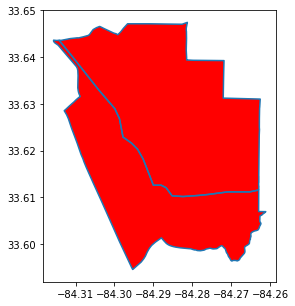

In [44]:
# Ellenwood was split into Ellenwood 1 and 2
ax = ga_18_shps[(ga_18_shps["CTYNAME"]=="CLAYTON")& (ga_18_shps["PRECINCT_N"]=="ELLENWOOD")].plot(figsize = (5,5), color = "red")
vest_ga_20[(vest_ga_20["CTYNAME"]=="CLAYTON") & (vest_ga_20["PRECINCT_N"].isin(["ELLENWOOD 1", "ELLENWOOD 2"]))].boundary.plot(ax = ax)

<AxesSubplot:>

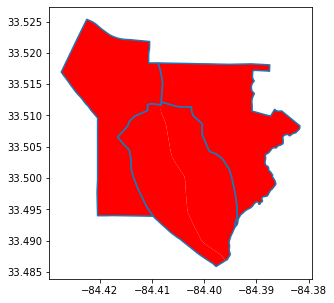

In [45]:
#### Note: Jonesboro 19 comes from parts of both Jonesboro 17 and Jonesboro 1. We will download a 2018 shapefile and use that here
ax = ga_18_shps[(ga_18_shps["CTYNAME"]=="CLAYTON")& (ga_18_shps["PRECINCT_N"].isin(["JONESBORO 1", "JONESBORO 17"]))].plot(figsize = (5,5), color = "red")
vest_ga_20[(vest_ga_20["CTYNAME"]=="CLAYTON") & (vest_ga_20["PRECINCT_N"].isin(["JONESBORO 1", "JONESBORO 17", "JONESBORO 19"]))].boundary.plot(ax = ax)

<AxesSubplot:>

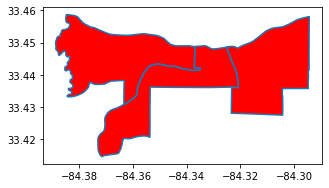

In [46]:
ax = ga_18_shps[(ga_18_shps["CTYNAME"]=="CLAYTON")& (ga_18_shps["PRECINCT_N"].isin(["LOVEJOY 3"]))].plot(figsize = (5,5), color = "red")
vest_ga_20[(vest_ga_20["CTYNAME"]=="CLAYTON") & (vest_ga_20["PRECINCT_N"].isin(["LOVEJOY 3", "LOVEJOY 6", "LOVEJOY 7"]))].boundary.plot(ax = ax)

<AxesSubplot:>

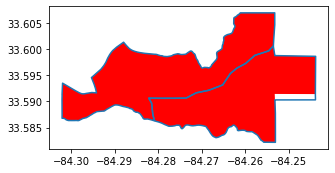

In [47]:
ax = ga_18_shps[(ga_18_shps["CTYNAME"]=="CLAYTON")& (ga_18_shps["PRECINCT_N"].isin(["MORROW 5"]))].plot(figsize = (5,5), color = "red")
vest_ga_20[(vest_ga_20["CTYNAME"]=="CLAYTON") & (vest_ga_20["PRECINCT_N"].isin(["MORROW 10", "MORROW 5"]))].boundary.plot(ax = ax)

<AxesSubplot:>

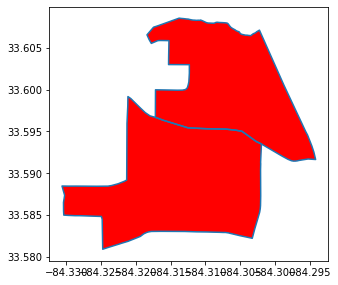

In [48]:
ax = ga_18_shps[(ga_18_shps["CTYNAME"]=="CLAYTON")& (ga_18_shps["PRECINCT_N"].isin(["MORROW 3"]))].plot(figsize = (5,5), color = "red")
vest_ga_20[(vest_ga_20["CTYNAME"]=="CLAYTON") & (vest_ga_20["PRECINCT_N"].isin(["MORROW 11", "MORROW 3"]))].boundary.plot(ax = ax)

<AxesSubplot:>

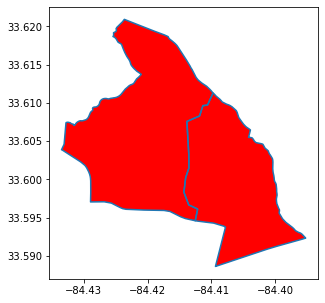

In [49]:
ax = ga_18_shps[(ga_18_shps["CTYNAME"]=="CLAYTON")& (ga_18_shps["PRECINCT_N"].isin(["OAK 3"]))].plot(figsize = (5,5), color = "red")
vest_ga_20[(vest_ga_20["CTYNAME"]=="CLAYTON") & (vest_ga_20["PRECINCT_N"].isin(["OAK 5", "OAK 3"]))].boundary.plot(ax = ax)

In [50]:
# Finish the replacement
vest_ga_20 = gp.GeoDataFrame(pd.concat([vest_ga_20_no_clayton, ga_18_shps_clayton]), crs = 4019)

### Other Counties - Undo Splits

Fulton
- '121-02A1' - Merge back with 02A
-  '121-02L1A' - Merge back with 02L1
-  '121-06D1' - Merge back to create 06D
-  '121-06D2' - Merge back to create 06D
-  '121-09K1' - Merge back to create 09K
-  '121-11B1' - 11B
-  '121-11M1' - Merge back to create 11M
-  '121-12A1' - Merge back to create 12A
-  '121-EP04C' - Merge back to EP04A
-  '121-FA01D' - FA01B
-  '121-JC01A' - JC01
-  '121-ML03A' - ML03
-  '121-RW09A' - RW09
-  '121-RW12A' - RW12
-  '121-SC07D' - SC07A
-  '121-SC15A' - SC15
-  '121-UC02C' - UC02A

In [51]:
precinct_merges_dict = {
# Undoing VEST split of Marietta 3A/3B from documentation                       
 '067-MARIETTA 3B':'067-MARIETTA 3A',                       

# Undoing VEST split of Cassville / Hamilton Crossing from documentation
'015-HAMILTON CROSSING':'015-CASSVILLE',
                        
# Article about Lowndes splits https://www.valdostadailytimes.com/news/local_news/lowndes-adds-two-voting-precincts-for-november/article_36adc875-18e6-53fe-8dc0-1cf1a0ed85ba.htmlhttps://www.valdostadailytimes.com/news/local_news/lowndes-adds-two-voting-precincts-for-november/article_36adc875-18e6-53fe-8dc0-1cf1a0ed85ba.html
'185-MT CALVARY':'185-JAYCEE SHACK',
'185-NORTHGATE ASSEMBLY':'185-TRINITY',

'121-02A1':'121-02A',
'121-02L1A':'121-02L1',
'121-06D1':'121-06D',
'121-06D2':'121-06D',
'121-09K1':'121-09K',
'121-11B1':'121-11B',
'121-11M1':'121-11M',
'121-12A1':'121-12A',
'121-EP04C':'121-EP04A',
'121-FA01D':'121-FA01B',
'121-JC01A':'121-JC01',
'121-ML03A':'121-ML03',
'121-RW09A':'121-RW09',
'121-RW12A':'121-RW12',
'121-SC07D':'121-SC07A',
'121-SC15A':'121-SC15',
'121-UC02C':'121-UC02A'
    
                        
}

In [52]:
# Dissolve on this column (this will not affect any other precincts)
vest_ga_20["unique_ID_dissolve"] = vest_ga_20["unique_ID"].map(precinct_merges_dict).fillna(vest_ga_20["unique_ID"])
vest_ga_20_mod = vest_ga_20.dissolve("unique_ID_dissolve")

# Clean up the columns
vest_ga_20_mod.reset_index(inplace = True, drop = False)

# Clean up the Fulton precincts
def mod_id(precinct_id):
    if "-" in precinct_id:
        return precinct_id.split("-")[1]
    else:
        print(precinct_id[3:])
        return precinct_id[3:]
    
vest_ga_20_mod["PRECINCT_N"] = vest_ga_20_mod["unique_ID_dissolve"].apply(lambda x: mod_id(x))

vest_ga_20_mod["PRECINCT_I"] = np.where(vest_ga_20_mod["CTYNAME"]=="FULTON", vest_ga_20_mod["PRECINCT_N"], vest_ga_20_mod["PRECINCT_I"])

FTSTEW
XFTPU
FTBEN1
FTBEN2
FTBEN3
FTBEN4
ZZZZZZ


## Final Join

In [53]:
# Use of modified unique_ID column from the above
vest_ga_20_mod.drop(["unique_ID"], inplace = True, axis = 1)

vest_ga_20_mod.rename(columns = {"unique_ID_dissolve":"unique_ID"}, inplace = True)

In [54]:
#Last join attempt
join_attempt_4 = gp.GeoDataFrame(pd.merge(vest_ga_20_mod,ga_election,how="outer",on="unique_ID",indicator=True), crs = 4019)
print(join_attempt_4["_merge"].value_counts())

both = join_attempt_4[join_attempt_3["_merge"]=="both"]
left_only = join_attempt_4[join_attempt_4["_merge"]=="left_only"]
right_only = join_attempt_4[join_attempt_4["_merge"]=="right_only"]

both          2627
left_only       24
right_only       0
Name: _merge, dtype: int64


/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


In [55]:
#Confirm that the unjoined precincts contain zero-votes
empty_precincts = []
for index, row in left_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["DISTRICT"])
print(len(empty_precincts))  

24


## Clean the Joined File and Separate Based on Election Level

In [56]:
# Clean the data columns
primary_columns_list = [i for i in join_attempt_4.columns if i in list(race_updates_dict.values())]
for val in primary_columns_list:
    join_attempt_4[val] = join_attempt_4[val].fillna(0)
    join_attempt_4[val] = join_attempt_4[val].astype(int)

In [57]:
# Define a list of columns we want across all files
standard_keep_columns = ['unique_ID', 'geometry', 'DISTRICT', 'CTYSOSID', 'PRECINCT_I',
       'PRECINCT_N', 'CTYNAME', 'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', "county_fips"]

In [58]:
# Define a list of columns particular to the different files
sldl_cols = [i for i in primary_columns_list if i[1:3] == "SL"]
sldu_cols = [i for i in primary_columns_list if i[1:3] == "SU"] + ['SRSU04RBOH', 'SRSU04RHIC']
cong_cols = [i for i in primary_columns_list if i[1:3] == "CO"]
st_cols = [i for i in primary_columns_list if i not in sldl_cols and i not in sldu_cols and i not in cong_cols]

In [59]:
# Make sure all the columns are accounted for
print(len(primary_columns_list))
print(len(sldl_cols))
print(len(sldu_cols))
print(len(cong_cols))
print(len(st_cols))

print(len(sldl_cols) + len(sldu_cols)+ len(cong_cols)+ len(st_cols))

622
366
145
85
26
622


## Separate out Files

In [60]:
ga_prim_20_sldl = join_attempt_4[standard_keep_columns + sldl_cols].copy(deep = True)
ga_prim_20_sldu = join_attempt_4[standard_keep_columns + sldu_cols].copy(deep = True)
ga_prim_20_cong = join_attempt_4[standard_keep_columns + cong_cols].copy(deep = True)
ga_prim_20_st = join_attempt_4[standard_keep_columns + st_cols].copy(deep = True)

## Look into split precincts

In [61]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one
    
def get_level_dist(column_name):
    if column_name[0:4] == "SRSU":
        level = "SU"
        dist = "04"
    elif column_name[0:3] == "PSL":
        level = "SL"
        dist = column_name[3:6]
    elif column_name[0:3] == "RSL":
        level = "SL"
        dist = column_name[3:6]
    elif column_name[0:3] == "PCO":
        level = "CON"
        dist = column_name[4:6]
    elif column_name[0:3] == "RCO":
        level = "CON"
        dist = column_name[4:6]
    elif column_name[0:3] in ["PSU", "RSU", "SSU"]:
        level = "SU"
        dist = column_name[3:5]
    else:
        print(column_name)
        raise ValueError
    return level,dist

def contains_sldl(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SL":
            return dist_tuple[1]
        
def contains_cong(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "CON":
            return dist_tuple[1]

### Find the Precinct Splits in the Various Files

In [62]:
precinct_mapping_dict_sldu = {}
split_precincts_list_sldu = {}
for index,row in ga_prim_20_sldu.iterrows():
    precinct_list = []
    for contest in sldu_cols:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list_sldu[row["unique_ID"]]=is_split
    precinct_mapping_dict_sldu[row["unique_ID"]]=precinct_list

In [63]:
precinct_mapping_dict_sldl = {}
split_precincts_list_sldl = {}
for index,row in ga_prim_20_sldl.iterrows():
    precinct_list = []
    for contest in sldl_cols:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list_sldl[row["unique_ID"]]=is_split
    precinct_mapping_dict_sldl[row["unique_ID"]]=precinct_list

In [64]:
precinct_mapping_dict_cong = {}
split_precincts_list_cong = {}
for index,row in ga_prim_20_cong.iterrows():
    precinct_list = []
    for contest in cong_cols:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list_cong[row["unique_ID"]]=is_split
    precinct_mapping_dict_cong[row["unique_ID"]]=precinct_list

In [65]:
def return_dict_value(dictionary, value):
    try:
        return dictionary[value][0][1]
    except IndexError:
        print(value)
        return "N/A"

In [66]:
# Initialize the DIST columns, for the moment just setting the DIST to the first value if there are splits

print("Adding SLDL")
ga_prim_20_sldl["SLDL_DIST"] = ga_prim_20_sldl["unique_ID"].apply(lambda x: return_dict_value(precinct_mapping_dict_sldl, x))
print("Adding SLDU")
ga_prim_20_sldu["SLDU_DIST"] = ga_prim_20_sldu["unique_ID"].apply(lambda x: return_dict_value(precinct_mapping_dict_sldu, x))
print("Adding CONG")
ga_prim_20_cong["CONG_DIST"] = ga_prim_20_cong["unique_ID"].apply(lambda x: return_dict_value(precinct_mapping_dict_cong, x))

Adding SLDL
029FTSTEW
051XFTPU
121-01I
121-03P1B
121-08F2
121-12E2
121-AP01E
121-AP12D
121-CP052
121-CP053
121-CP06B
121-CP07B
121-CP084
121-RW11B
121-RW22B
121-SC07B
121-SC08A
121-SC17B
121-SC21A
121-SC29B
121-UC01C
121-UC01D
121-UC033
215FTBEN1
215FTBEN2
215FTBEN3
215FTBEN4
215ZZZZZZ
Adding SLDU
029FTSTEW
051XFTPU
121-01I
121-03P1B
121-08F2
121-12E2
121-AP01E
121-AP12D
121-CP052
121-CP053
121-CP06B
121-CP07B
121-CP084
121-RW11B
121-RW22B
121-SC07B
121-SC08A
121-SC08G
121-SC08H
121-SC17B
121-SC21A
121-SC29B
121-UC01C
121-UC01D
121-UC033
179-BUTTON GWINNETT
179-FLEMING EAST
179-FLEMING WEST
179-HINESVILLE
179-LIBERTY COUNTY COMPLEX
179-LYMAN HALL SCHOOL
179-MEMORIAL DR EAST
179-RICEBORO YOUTH CENTER
179-TOWN OF ALLENHURST
215FTBEN1
215FTBEN2
215FTBEN3
215FTBEN4
215ZZZZZZ
Adding CONG
029FTSTEW
051XFTPU
121-01I
121-03P1B
121-08F2
121-12E2
121-AP01E
121-AP12D
121-CP052
121-CP053
121-CP06B
121-CP07B
121-CP084
121-RW11B
121-RW22B
121-SC07B
121-SC08A
121-SC08G
121-SC08H
121-SC17B
121-SC21A
1

In [67]:
# Make a copy of the dataframes to see whether votes are list from precinct splits
ga_prim_20_sldl_presplit = ga_prim_20_sldl.copy(deep = True)
ga_prim_20_sldu_presplit = ga_prim_20_sldu.copy(deep = True)
ga_prim_20_cong_presplit = ga_prim_20_cong.copy(deep = True)

### Perform the Precinct Splits

In [68]:
for val in ga_prim_20_sldl["unique_ID"]:
    if val in split_precincts_list_sldl.keys():
        print(val)
        ga_prim_20_sldl = helper_functions.district_splits_mod(split_precincts_list_sldl[val],"SL",val, ga_prim_20_sldl, ga_sldl_districts, "unique_ID", "SLDL_DISTRICT", sldl_cols, "SLDL_DIST")
        
for val in ga_prim_20_sldu["unique_ID"]:
    if val in split_precincts_list_sldu.keys():
        print(val)
        ga_prim_20_sldu = helper_functions.district_splits_mod(split_precincts_list_sldu[val],"SU",val, ga_prim_20_sldu, ga_sldu_districts, "unique_ID", "SLDU_DISTRICT", sldu_cols, "SLDU_DIST")
        
for val in ga_prim_20_cong["unique_ID"]:
    if val in split_precincts_list_cong.keys():
        print(val)
        ga_prim_20_cong = helper_functions.district_splits_mod(split_precincts_list_cong[val],"CON",val, ga_prim_20_cong, ga_cong_districts, "unique_ID", "CONG_DISTRICT", cong_cols, "CONG_DIST")

001-3C


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


013-01 BETHLEHEM COMMUNITY CENTER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


013-05 FIRE STATION 1 (STATHAM)


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


013-08 FIRST BAPTIST CHURCH WINDER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


013-16 THE CHURCH AT WINDER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


015-CARTERSVILLE EAST


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


015-CENTER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


015-EUHARLEE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


021-GODFREY 1
021-VINEVILLE 4
029-DANIELSIDING


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


029-HWY 144 EAST


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


029-JF GREGORY PARK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


031-HAGIN


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


031-REGISTER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


035-BUTTS COUNTY ADMIN BLDG


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


039-KINGSLAND
045-BETHANY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


045-CLEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


049-AMERICAN LEGION


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


051-LIGHTHOUSE BAPTIST CHURCH
051-TRINITY LUTHERAN CHURCH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


051-WINDSOR FOREST BAPTIST


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-AIR ACRES


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-AVERY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-HICKORY FLAT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-NEESE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-TEASLEY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-UNIVETER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


059-4B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


059-7A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


063-JONESBORO 11


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


063-JONESBORO 3


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


063-LAKE CITY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


063-LOVEJOY 1


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


063-LOVEJOY 5


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-BIG SHANTY 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-CHEATHAM HILL 03


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 14 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-CLARKDALE 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-CLARKDALE 02


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 55 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-DURHAM 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 24 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-ELIZABETH 01
067-ELIZABETH 03


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 8 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-KENNESAW 1A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-KENNESAW 2A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 13 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-KENNESAW 3A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 10 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-KENNESAW 4A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-LASSITER 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 21 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MABLETON 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 30 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 1A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 2A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 2B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 3A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 31 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 4A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 4B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 5A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 21 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 5B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 6A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 80 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 7A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 32 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-NICKAJACK 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-NORTON PARK 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 21 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-OAKDALE 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 8 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-OREGON 02


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-OREGON 03


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-PINE MOUNTAIN 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 27 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-POPE 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-POWERS FERRY 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SEWELL MILL 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 29 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SEWELL MILL 03


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 34 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 1A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 2A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 3B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 5A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 7A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 34 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-TERRELL MILL 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 51 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-VININGS 03


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


069-BROXTON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


077-CENTRAL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


077-NEWNAN CENTRE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


077-TURIN


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


087-BAINBRIDGE-COLISEUM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-AVONDALE HIGH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-CHAMBLEE 2


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-CLAIREMONT WEST


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-CLARKSTON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-CLARKSTON COMMUNITY CENTER
089-CROSSROADS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-DORAVILLE NORTH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 14 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-DRESDEN ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-EAST LAKE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-EMBRY HILLS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-EVANSDALE ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-FERNBANK ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 22 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-GLENNWOOD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-HUNTLEY HILLS ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 8 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-JOLLY ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-LAKESIDE HIGH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-MIDVALE ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-MILLER GROVE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 27 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-MONTREAL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-PANOLA ROAD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-PLEASANTDALE ROAD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-PRINCETON ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-REDAN MIDDLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 12 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-ROCKBRIDGE ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-SKYLAND


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-STONE MTN MIDDLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-TUCKER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 18 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-TUCKER LIBRARY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 15 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-WINNONA PARK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-WOODWARD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


095-DARTON COLLEGE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


097-CHESTNUT LOG


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


103-4B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


113-FIELDING RIDGE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


113-KEDRON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


113-MORNING CREEK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


113-OAK RIDGE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


113-WILLOW POND


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


115-MT ALTO NORTH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


115-NORTH ROME


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


115-TOWN ROME
117-01 BIG CREEK
117-03 BROWNS BRIDGE
117-05 COAL MOUNTAIN
117-07 CUMMING
117-08 MASHBURN
117-10 MIDWAY
117-15 HEARDSVILLE
117-16 OTWELL
117-25 WINDERMERE
117-27 CONCORD
117-29 POLO
117-36 NICHOLS
129-RED BUD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


129-SONORAVILLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-BAYCREEK H


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 8 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-CATES J


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 40 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-DULUTH C


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 16 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-DULUTH F


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 15 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-DULUTH I


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 13 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-GARNERS D


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-HARBINS A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 26 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-HOG MOUNTAIN B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-HOG MOUNTAIN C


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-LAWRENCEVILLE D


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 27 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-MARTINS A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-PINCKNEYVILLE W


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-PINCKNEYVILLE Y


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 21 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-ROCKBRIDGE C


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 29 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-SUGAR HILL A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


137-HABERSHAM NORTH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


137-HABERSHAM SOUTH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-CHICOPEE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-FRIENDSHIP III


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-FRIENDSHIP IV


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-GAINESVILLE II


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-GAINESVILLE III


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-GAINESVILLE IV


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-GLADE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-OAKWOOD I
139-ROBERTS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-TADMORE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-WHELCHEL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-WILSON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


143-FELTON
143-LITTLE CREEK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-FLIPPEN


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-HICKORY FLAT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-MCDONOUGH CENTRAL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-MT CARMEL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-STOCKBRIDGE EAST-WEST


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-SWAN LAKE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


151-TUSSAHAW


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-BMS
153-CENT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-HHPC


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-RECR


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-ROZR


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-TWPK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-VHS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


157-SOUTH JACKSON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


161-OCMULGEE 2
167-WRIGHTSVILLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


169-POPE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-CLYATTVILLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-DASHER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-HAHIRA TRAIN DEPOT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-NORTHSIDE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-RAINWATER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-TRINITY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


195-MILL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


207-FORSYTH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


213-TOWN


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-CANAAN


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-CUSSETA RD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-EPWORTH UMC


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-GENTIAN/REESE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-HOLSEY/BUENA VISTA


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-OUR LADY OF LOURDES


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-ST ANDREWS/MIDLAND


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


217-BREWERS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


217-COVINGTON MILLS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


217-DOWNS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


217-LIVINGSTON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-D WRIGHT INNOVATION CTR


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 25 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-MULBERRY ROCK PARK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-NEBO ELEM SCHOOL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-RUSSOM ELEMENTARY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-SHELTON ELEMENTARY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-TAYLOR FARM PARK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 12 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-WHITE OAK PARK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


237-104


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


247-BT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


247-FI


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


247-FS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


247-HI


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


247-MA


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


247-OT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


255-05


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


255-08
255-19


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


275-FIRE STATION #2


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


277-BRIGHTON
277-MOTT-LITMAN GYM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


277-TIFTON LODGE
277-TIFTON NORTHWEST


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


285-ADMINISTRATION BLDG


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 21 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


285-HIGHLAND
285-HOGANSVILLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


285-LONG CANE
285-MCCLENDON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


285-NORTHSIDE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


285-ROSEMONT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


295-CHICKAMAUGA


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


295-WALNUT GROVE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


297-BAY CREEK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


297-BETWEEN


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


299-District 1


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


299-District 2A
299-District 2B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


305-PINE STREET


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


305-REC CENTER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


311-SHOAL CREEK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


313-2A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


015-ADAIRSVILLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


015-CARTERSVILLE EAST
015-CARTERSVILLE WEST


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


015-EMERSON
021-HOWARD 3
021-RUTLAND 2
045-ROOPVILLE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


049-AMERICAN LEGION


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


049-RACEPOND


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


051-THUNDERBOLT MUNI COMPLEX
057-BASCOMB


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-BOOTH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


057-LITTLE RIVER
067-EAST PIEDMONT 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-EASTSIDE 02


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-ELIZABETH 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 26 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-ELIZABETH 04


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 45 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-KENNESAW 1A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MABLETON 02


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 14 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 1A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 13 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 2A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 5B
067-MARIETTA 6A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 7A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-NICKAJACK 01
067-OAKDALE 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 31 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-OREGON 03


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 12 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-PALMER 01
067-SMYRNA 3B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 4A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 18 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 5A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 29 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 6A
067-TERRELL MILL 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 10 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


073-HARLEM BRANCH LIBRARY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 12 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


073-SECOND MT MORIAH BAPTIST CHURCH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 44 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-AVONDALE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-BROOKHAVEN


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 12 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-DRESDEN ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-EAST LAKE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-MCLENDON
089-MCNAIR


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-MILLER GROVE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-PANOLA ROAD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-PRINCETON ELEM


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-TUCKER LIBRARY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 14 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


117-06 CROSSROADS
121-CH02


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


129-RESACA


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-BERKSHIRE Q
135-CATES L


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 17 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-LAWRENCEVILLE H


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 48 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


135-PINCKNEYVILLE K
135-ROCKYCREEK A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 18 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


139-TADMORE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-HHPC


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-NSES


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-RECR


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


153-TMS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


157-CENTRAL JACKSON


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


169-CLINTON
215-COLUMBUS TECH
215-EPWORTH UMC


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-ST PAUL/CLUBVIEW


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-NEBO ELEM SCHOOL


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


223-TAYLOR FARM PARK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


227-JASPER
261-REESE PARK


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


285-LONG CANE
285-ROSEMONT


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


297-BLASINGAME
315-ABBEVILLE NORTH 2


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


315-ROCHELLE SOUTH 4


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


021-HAZZARD 4
021-HOWARD 1
067-CHATTAHOOCHEE 01
067-EAST PIEDMONT 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-FAIR OAKS 04
067-MARIETTA 5A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-MARIETTA 6A
067-MARIETTA 7A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-PALMER 01
067-POWERS FERRY 01


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 3A
067-SMYRNA 4A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 22 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


067-SMYRNA 6A
067-SMYRNA 7A


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 22 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


073-HARLEM BRANCH LIBRARY
073-HARLEM SENIOR CENTER


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 26 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


073-KIOKEE BAPTIST CHURCH
089-AVONDALE HIGH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-GLENNWOOD
089-WADSWORTH


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 7 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


089-WINNONA PARK
103-1B


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


103-4B
113-DOGWOOD


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


113-SANDY CREEK
117-03 BROWNS BRIDGE
117-16 OTWELL
117-37 SAWNEE
135-CATES D
151-UNITY GROVE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


185-NAYLOR
185-TRINITY


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


215-EPWORTH UMC
215-ST PAUL/CLUBVIEW


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


217-ALCOVY
217-ROCKY PLAINS


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


227-JASPER
227-TATE


/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")
/Users/peterhorton/Documents/RDH/erj/erj-ga/2020/primary/helper_functions.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  test_join = gp.overlay(full_shape, shps_gdf, how = "intersection")


### Clean the DataFrame and Filter Columns

In [69]:
ga_prim_20_sldl.rename(columns = {'unique_ID':"UNIQUE_ID", 'county_fips':'COUNTYFP'}, inplace = True)
ga_prim_20_sldl = ga_prim_20_sldl[["UNIQUE_ID", 'COUNTYFP','DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2','SLDL_DIST']+sldl_cols+["geometry"]]

In [70]:
ga_prim_20_sldu.rename(columns = {'unique_ID':"UNIQUE_ID", 'county_fips':'COUNTYFP'}, inplace = True)
ga_prim_20_sldu = ga_prim_20_sldu[["UNIQUE_ID", 'COUNTYFP','DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2','SLDU_DIST']+sldu_cols+["geometry"]]

In [71]:
ga_prim_20_cong.rename(columns = {'unique_ID':"UNIQUE_ID", 'county_fips':'COUNTYFP'}, inplace = True)
ga_prim_20_cong = ga_prim_20_cong[["UNIQUE_ID", 'COUNTYFP','DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2','CONG_DIST']+cong_cols+["geometry"]]

In [72]:
ga_prim_20_st.rename(columns = {'unique_ID':"UNIQUE_ID", 'county_fips':'COUNTYFP'}, inplace = True)
ga_prim_20_st = ga_prim_20_st[["UNIQUE_ID", 'COUNTYFP','DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2']+st_cols+["geometry"]]

### Deal with N/A District Assignments

In [73]:
ga_prim_20_sldl[ga_prim_20_sldl["SLDL_DIST"]=="N/A"]
ga_prim_20_sldu[ga_prim_20_sldu["SLDU_DIST"]=="N/A"]
ga_prim_20_cong[ga_prim_20_cong["CONG_DIST"]=="N/A"]

,UNIQUE_ID,COUNTYFP,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,...,PCON14RLAU,RCON01DGRI,RCON01DRIN,RCON09DPAN,RCON09DSIS,RCON09RCLY,RCON09RGUR,RCON14RCOW,RCON14RGRE,geometry
127,029FTSTEW,NaN,029FTSTEW,None,None,FTSTEW,None,None,None,None,...,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-81.59242 32.10347, -81.59241 ..."
320,051XFTPU,NaN,051XFTPU,None,None,XFTPU,None,None,None,None,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-80.96828 32.04402, -80.96876 32.044..."
1142,121-01I,NaN,12101I,12101I,01I,01I,FULTON,60,060,121,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.38645 33.75449, -84.38652 33.754..."
1175,121-03P1B,NaN,12103P1B,12103P1B,03P1B,03P1B,FULTON,60,060,121,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.40813 33.77318, -84.40764 33.773..."
1232,121-08F2,NaN,12108F2,12108F2,08F2,08F2,FULTON,60,060,121,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.45236 33.82719, -84.45220 33.827..."
1284,121-12E2,NaN,12112E2,12112E2,12E2,12E2,FULTON,60,060,121,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.42842 33.64877, -84.42843 33.654..."
1300,121-AP01E,NaN,121AP01E,121AP01E,AP01E,AP01E,FULTON,60,060,121,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.29795 34.03893, -84.29797 34.037..."
1317,121-AP12D,NaN,121AP12D,121AP12D,AP12D,AP12D,FULTON,60,060,121,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.25836 34.09181, -84.25818 34.091..."
1331,121-CP052,NaN,121CP052,121CP052,CP052,CP052,FULTON,60,060,121,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.48420 33.62904, -84.48421 33.623..."
1332,121-CP053,NaN,121CP053,121CP053,CP053,CP053,FULTON,60,060,121,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.48197 33.62309, -84.48200 33.623..."


In [74]:
def assign_values(gdf, gdf_dist_col_name, official_shapefile, source_dist_col_name, dist_col_identifier, id_col_name):
    na_values = gdf[gdf[gdf_dist_col_name]==dist_col_identifier]
    intersected = gp.overlay(official_shapefile, na_values, how = "intersection")
    intersected['area'] = intersected.area
    na_assignment_dict = {}
    for val in intersected[id_col_name].unique():
        assignment = intersected.loc[intersected[id_col_name] == val].nlargest(1, 'area')[source_dist_col_name].values[0]
        na_assignment_dict[val] = assignment
    return na_assignment_dict

In [75]:
sldl_na_dict = assign_values(ga_prim_20_sldl, "SLDL_DIST", ga_sldl_districts, "SLDL_DISTRICT",  "N/A", "UNIQUE_ID")
sldu_na_dict = assign_values(ga_prim_20_sldu, "SLDU_DIST", ga_sldu_districts, "SLDU_DISTRICT",  "N/A", "UNIQUE_ID")
cong_na_dict = assign_values(ga_prim_20_cong, "CONG_DIST", ga_cong_districts, "CONG_DISTRICT",  "N/A", "UNIQUE_ID")


/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_40397/2569391419.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 35 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersected = gp.overlay(official_shapefile, na_values, how = "intersection")
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_40397/2569391419.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersected['area'] = intersected.area
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_40397/2569391419.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersected = gp.overlay(official_shapefile, na_values, how = "intersection")
/var/folders/1t/0q4w6hm9

In [76]:
ga_prim_20_sldl["SLDL_DIST"] = ga_prim_20_sldl["UNIQUE_ID"].map(sldl_na_dict).fillna(ga_prim_20_sldl["SLDL_DIST"])
ga_prim_20_sldu["SLDU_DIST"] = ga_prim_20_sldu["UNIQUE_ID"].map(sldu_na_dict).fillna(ga_prim_20_sldu["SLDU_DIST"])
ga_prim_20_cong["CONG_DIST"] = ga_prim_20_cong["UNIQUE_ID"].map(cong_na_dict).fillna(ga_prim_20_cong["CONG_DIST"])

In [77]:
ga_prim_20_sldu["geometry"] = ga_prim_20_sldu["geometry"].buffer(0)

### Check the District Assignments

In [78]:
assigned_sldl_districts = ga_prim_20_sldl.dissolve(["SLDL_DIST"])
assigned_sldl_districts.reset_index(drop=False,inplace=True)

assigned_sldu_districts = ga_prim_20_sldu.dissolve(["SLDU_DIST"])
assigned_sldu_districts.reset_index(drop=False,inplace=True)

assigned_cong_districts = ga_prim_20_cong.dissolve(["CONG_DIST"])
assigned_cong_districts.reset_index(drop=False,inplace=True)

In [79]:
ga_sldl_districts["SLDL_DIST"] = ga_sldl_districts["SLDL_DISTRICT"]
ga_sldu_districts["SLDU_DIST"] = ga_sldu_districts["SLDU_DISTRICT"]
ga_cong_districts["CONG_DIST"] = ga_cong_districts["CONG_DISTRICT"]

Checking 180 districts for differences of greater than 0.1 km^2

1) For 033 difference in area is 0.2883494539283595
2) For 120 difference in area is 0.301049837214071
3) For 129 difference in area is 13.837790467301065
4) For 144 difference in area is 13.837790868653137
5) For 164 difference in area is 43.97139606259779
6) For 166 difference in area is 43.95951060110459

Scroll down to see plots of any differences

Of the 180 districts:

60 districts w/ a difference of 0 km^2
114 districts w/ a difference between 0 and .1 km^2
2 districts w/ a difference between .1 and .5 km^2
0 districts w/ a difference between .5 and 1 km^2
0 districts w/ a difference between 1 and 2 km^2
0 districts w/ a difference between 2 and 5 km^2
4 districts w/ a difference greater than 5 km^2


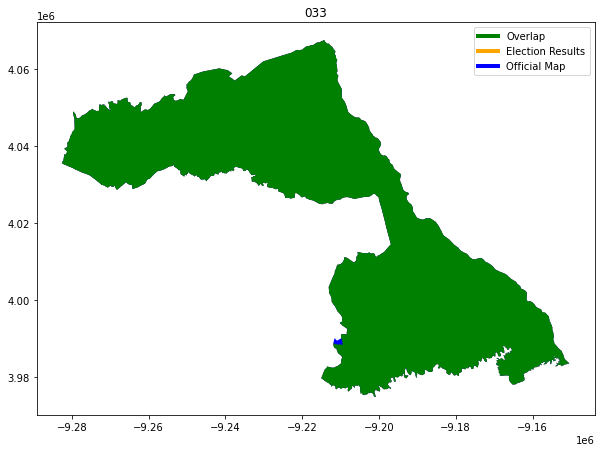

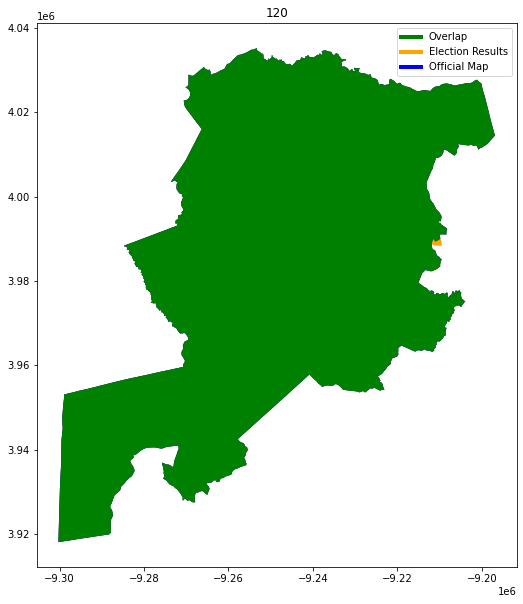

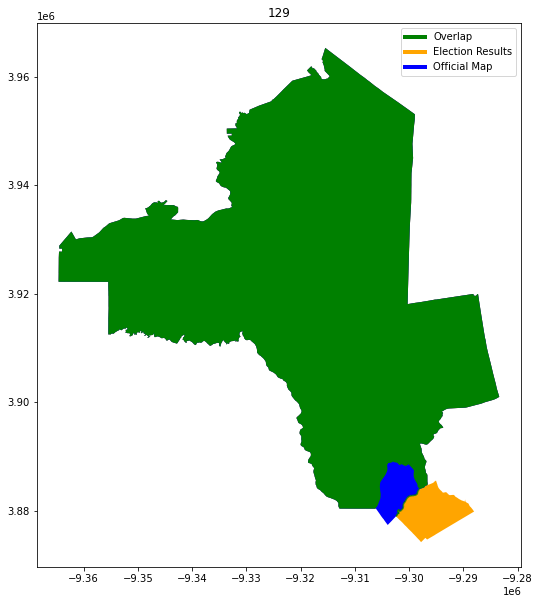

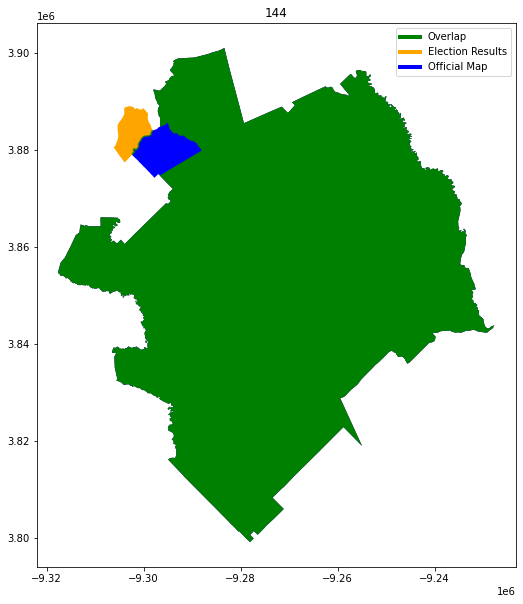

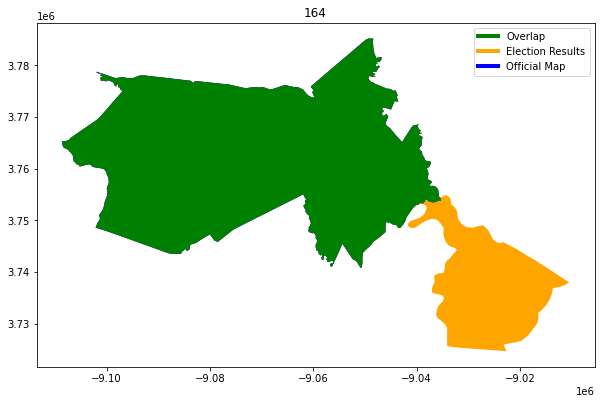

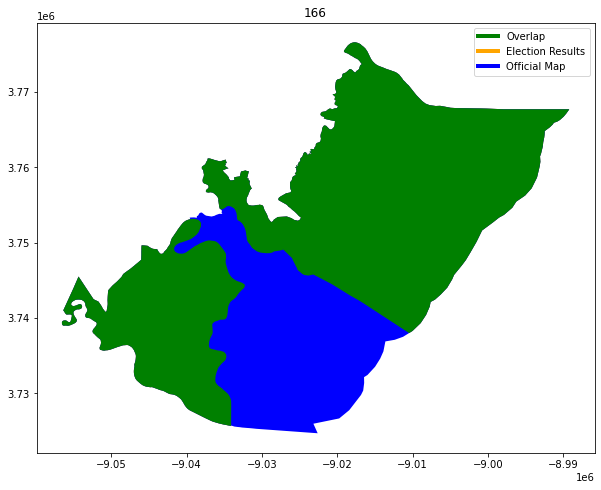

In [80]:
helper_functions.compare_geometries(assigned_sldl_districts, ga_sldl_districts ,"Election Results", "Official Map", "SLDL_DIST", "districts")

Checking 56 districts for differences of greater than 0.1 km^2

1) For 01 difference in area is 3.4930829436162902
2) For 04 difference in area is 10.301723070340403
3) For 06 difference in area is 0.12356552551072024
4) For 12 difference in area is 0.5094131396368865
5) For 13 difference in area is 0.5094131396368865
6) For 18 difference in area is 3.0767845524590642
7) For 19 difference in area is 13.79478726058908
8) For 28 difference in area is 0.12828075046918055
9) For 33 difference in area is 0.12458433577034483
10) For 35 difference in area is 0.21017810193722872
11) For 37 difference in area is 0.13019497038348882
12) For 39 difference in area is 0.18484225885971087
13) For 40 difference in area is 0.12860984017109003
14) For 41 difference in area is 0.14101157420004487

Scroll down to see plots of any differences

Of the 56 districts:

12 districts w/ a difference of 0 km^2
30 districts w/ a difference between 0 and .1 km^2
8 districts w/ a difference between .1 and .5 km^2
2

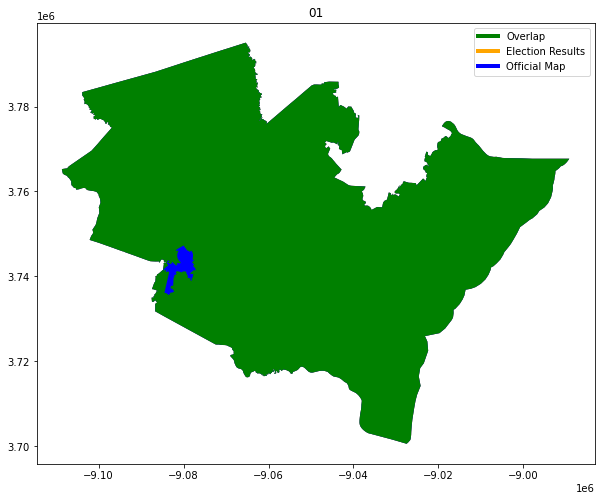

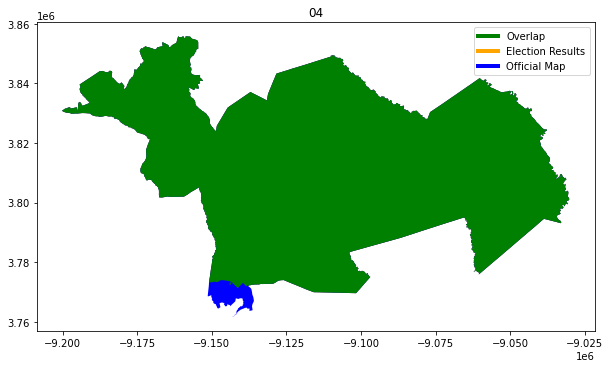

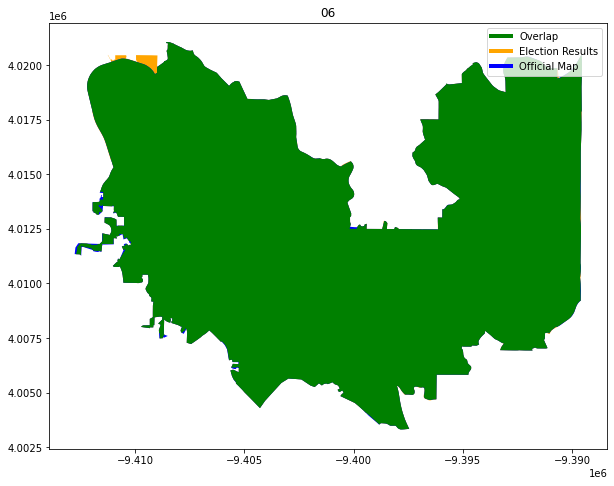

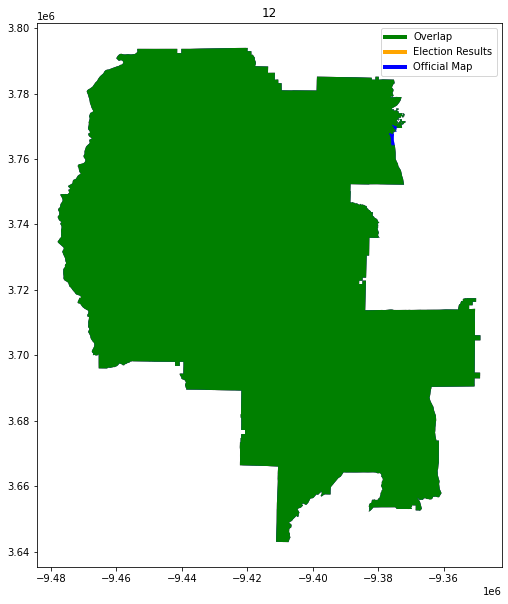

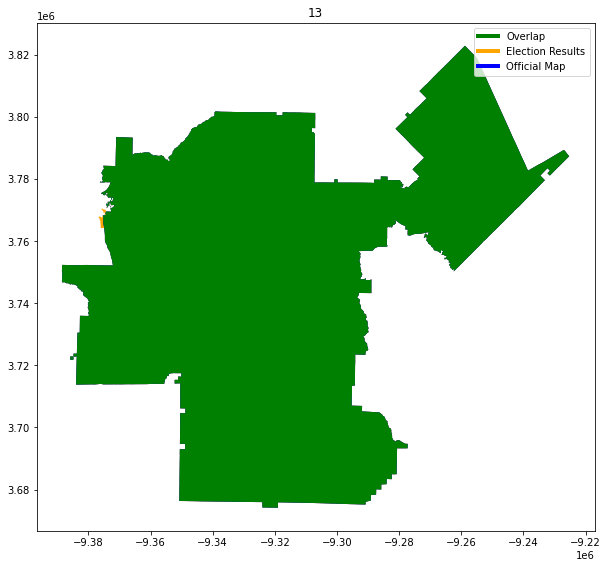

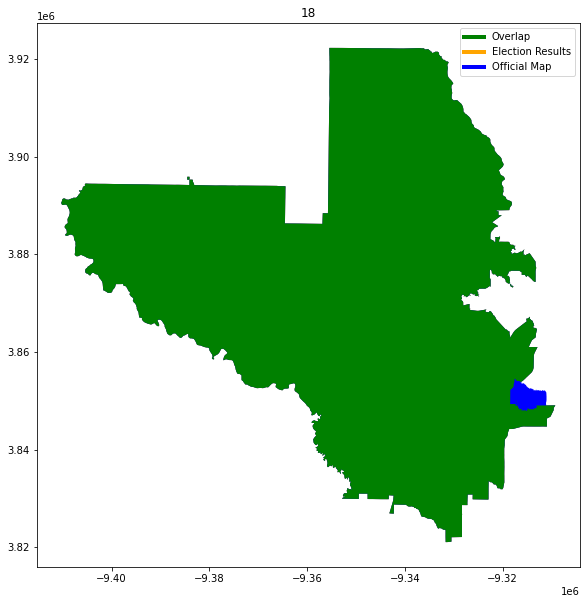

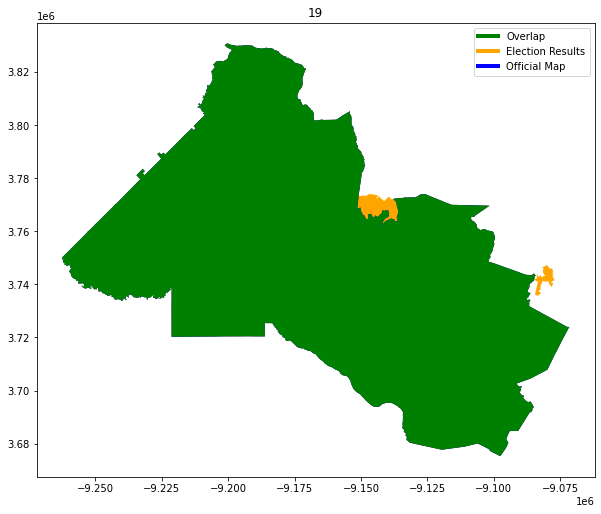

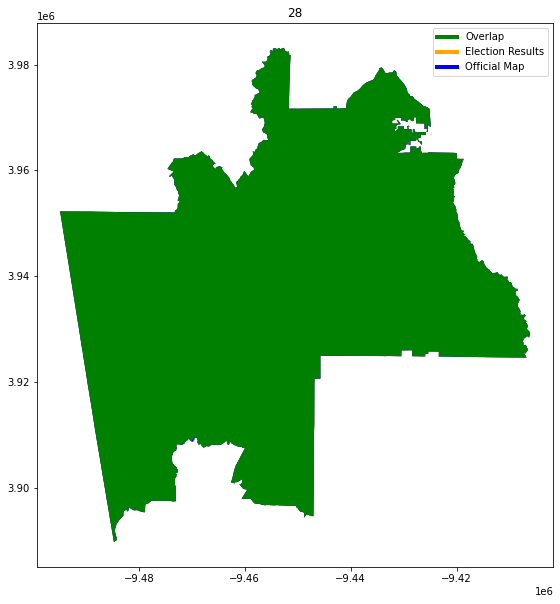

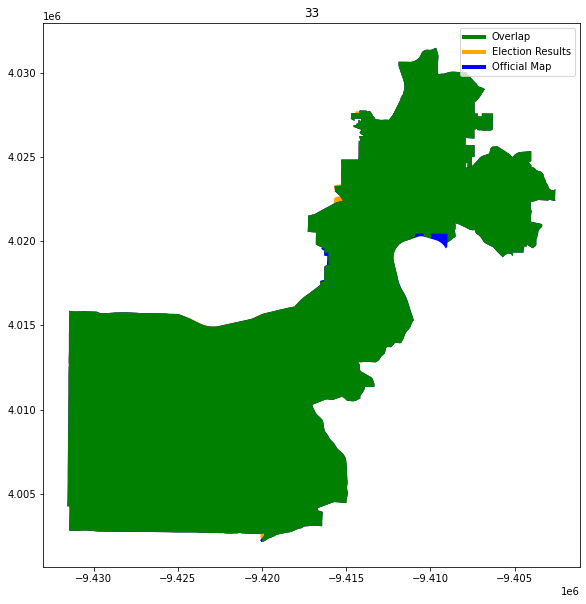

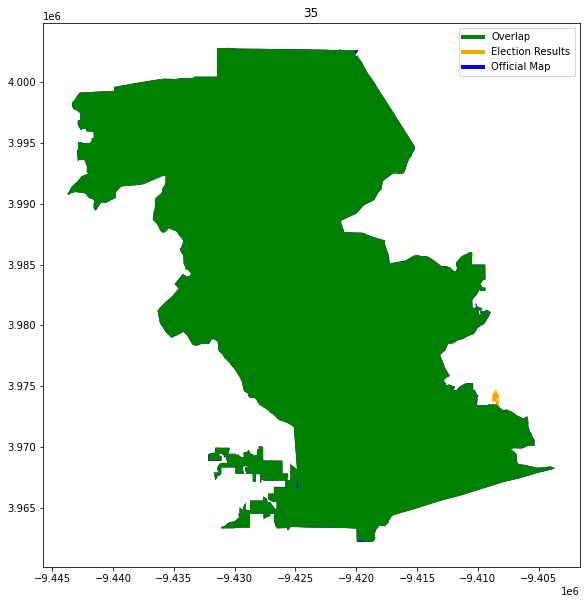

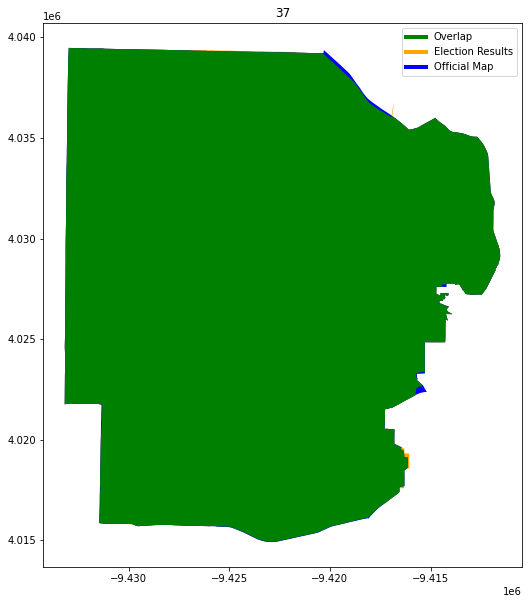

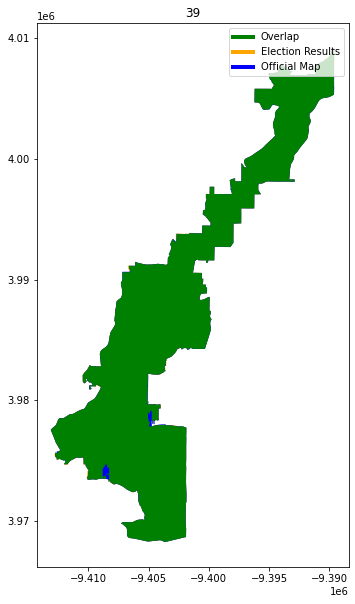

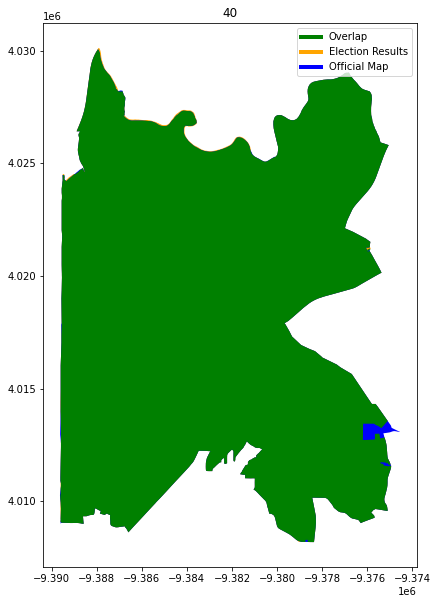

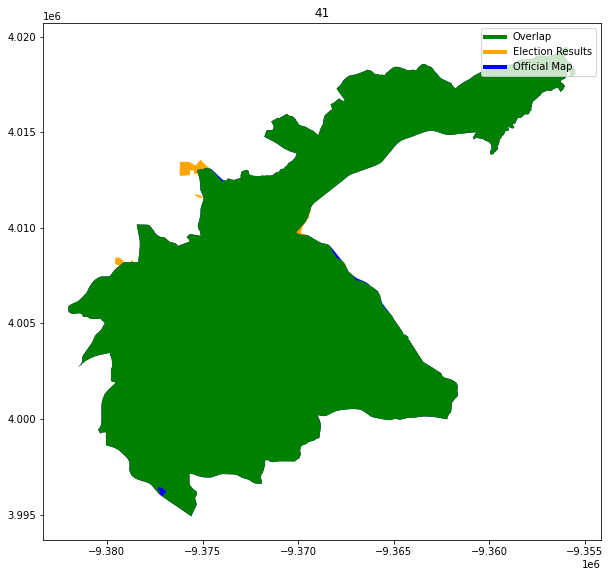

In [81]:
helper_functions.compare_geometries(assigned_sldu_districts, ga_sldu_districts ,"Election Results", "Official Map", "SLDU_DIST", "districts")


Checking 14 districts for differences of greater than 0.1 km^2

1) For 06 difference in area is 0.23580988567380462
2) For 11 difference in area is 0.226283767379122
3) For 13 difference in area is 0.11012688443459137

Scroll down to see plots of any differences

Of the 14 districts:

0 districts w/ a difference of 0 km^2
11 districts w/ a difference between 0 and .1 km^2
3 districts w/ a difference between .1 and .5 km^2
0 districts w/ a difference between .5 and 1 km^2
0 districts w/ a difference between 1 and 2 km^2
0 districts w/ a difference between 2 and 5 km^2
0 districts w/ a difference greater than 5 km^2


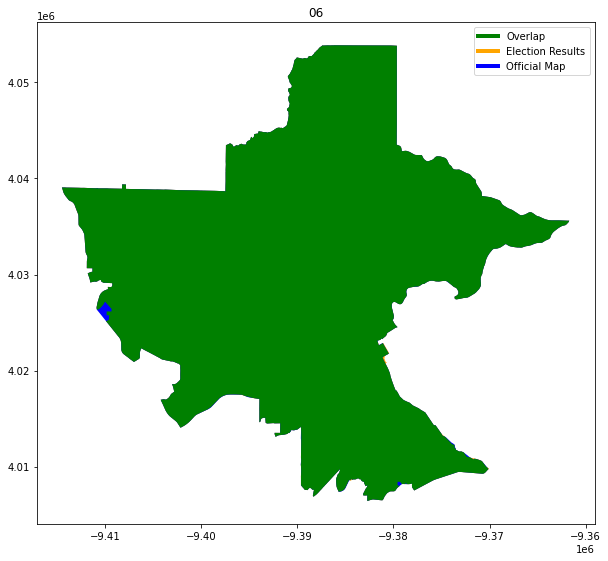

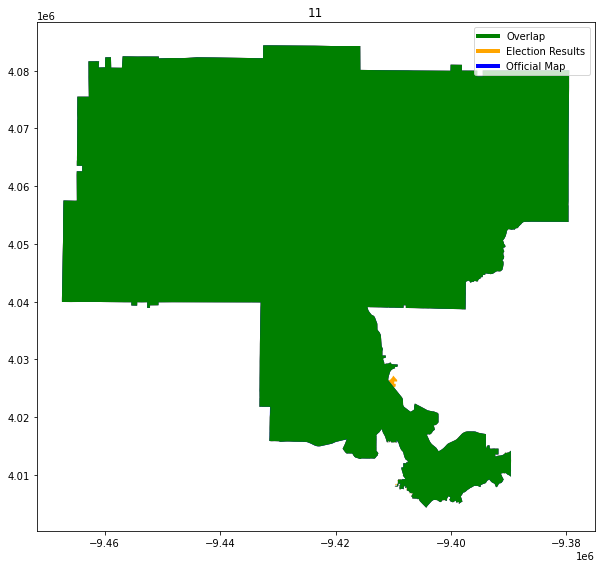

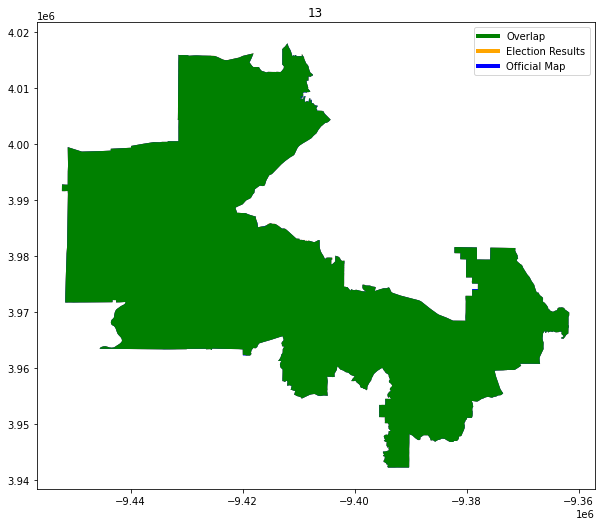

In [82]:
helper_functions.compare_geometries(assigned_cong_districts, ga_cong_districts ,"Election Results", "Official Map", "CONG_DIST", "districts")

### Check Added Column Totals

In the 'statewide-county-totals-check-erj-primary' we created a cleaned csv of the county totals from the GA sos website

In [96]:
official_county_totals = pd.read_csv("./official_county_totals.csv")
official_county_totals["CTYNAME"] = official_county_totals["county"].str.upper()

In [97]:
helper_functions.statewide_totals_check(official_county_totals, "Official Totals", ga_prim_20_sldl, "ERJ Totals", sldl_cols)

***Statewide Totals Check***
PSL001RCAM is equal 	 both dataframes 3166.0
PSL001RDEF is equal 	 both dataframes 3565.0
PSL001RMIL is equal 	 both dataframes 1810.0
PSL002RTAR is equal 	 both dataframes 8976.0
PSL003RHIL is equal 	 both dataframes 5349.0
PSL003RHOL is equal 	 both dataframes 3307.0
PSL004RCAR is equal 	 both dataframes 4649.0
PSL005RBAR is equal 	 both dataframes 6944.0
PSL006RRID is equal 	 both dataframes 7369.0
PSL007DDAY is equal 	 both dataframes 2193.0
PSL007RRAL is equal 	 both dataframes 12916.0
PSL008DCOO is equal 	 both dataframes 2780.0
PSL008RGUN is equal 	 both dataframes 9917.0
PSL008RTOW is equal 	 both dataframes 5273.0
PSL009DRAV is equal 	 both dataframes 1833.0
PSL009RLEI is equal 	 both dataframes 2748.0
PSL009RSHE is equal 	 both dataframes 2385.0
PSL009RSMI is equal 	 both dataframes 1107.0
PSL009RTOL is equal 	 both dataframes 954.0
PSL009RTUM is equal 	 both dataframes 1626.0
PSL009RWAD is equal 	 both dataframes 4617.0
PSL010DMIT is equal 	 both

In [99]:
helper_functions.statewide_totals_check(official_county_totals, "Official Totals", ga_prim_20_sldu, "ERJ Totals", sldu_cols)

***Statewide Totals Check***
PSU01DMCG is equal 	 both dataframes 10801.0
PSU01RWAT is equal 	 both dataframes 18078.0
PSU02DJAC has a difference of 143.0 votes
	Official Totals: 24026.0 votes
	ERJ Totals: 23883 votes
PSU03RMCN is equal 	 both dataframes 9219.0
PSU03RSHA is equal 	 both dataframes 9757.0
PSU03RSMI is equal 	 both dataframes 3379.0
PSU04RBOH is equal 	 both dataframes 9683.0
PSU04RHIC is equal 	 both dataframes 11190.0
PSU04RPAL is equal 	 both dataframes 4234.0
PSU04RSIN is equal 	 both dataframes 823.0
PSU05DRAH is equal 	 both dataframes 14904.0
PSU06DJOR is equal 	 both dataframes 25625.0
PSU06RLAN is equal 	 both dataframes 9859.0
PSU07RHAR has a difference of 3.0 votes
	Official Totals: 25504.0 votes
	ERJ Totals: 25501 votes
PSU08DGEA is equal 	 both dataframes 9103.0
PSU08RGOO is equal 	 both dataframes 14866.0
PSU10DJON is equal 	 both dataframes 33012.0
PSU10DRAE is equal 	 both dataframes 10286.0
PSU11RBUR is equal 	 both dataframes 17355.0
PSU12DBAL is equal 

In [100]:
helper_functions.statewide_totals_check(official_county_totals, "Official Totals", ga_prim_20_cong, "ERJ Totals", cong_cols)

***Statewide Totals Check***
PCON01DGRI has a difference of 47.0 votes
	Official Totals: 25593.0 votes
	ERJ Totals: 25546 votes
PCON01DRIN has a difference of 104.0 votes
	Official Totals: 28916.0 votes
	ERJ Totals: 28812 votes
PCON01DSEI has a difference of 15.0 votes
	Official Totals: 8337.0 votes
	ERJ Totals: 8322 votes
PCON01RCAR has a difference of 11.0 votes
	Official Totals: 65907.0 votes
	ERJ Totals: 65896 votes
PCON01RMER has a difference of 2.0 votes
	Official Totals: 13154.0 votes
	ERJ Totals: 13152 votes
PCON01RYAS is equal 	 both dataframes 1153.0
PCON02DBIS is equal 	 both dataframes 82964.0
PCON02RCHI is equal 	 both dataframes 20522.0
PCON02RCOL is equal 	 both dataframes 23528.0
PCON03DALM is equal 	 both dataframes 56240.0
PCON03RFER is equal 	 both dataframes 94166.0
PCON04DHAS is equal 	 both dataframes 19820.0
PCON04DJOH is equal 	 both dataframes 102227.0
PCON04DNIE is equal 	 both dataframes 27376.0
PCON04REZA is equal 	 both dataframes 23115.0
PCON05DLEW is equa

In [101]:
helper_functions.statewide_totals_check(official_county_totals, "Official Totals", ga_prim_20_st, "ERJ Totals", st_cols)

***Statewide Totals Check***
P20PREDBEN has a difference of 3.0 votes
	Official Totals: 5154.0 votes
	ERJ Totals: 5151 votes
P20PREDBID has a difference of 112.0 votes
	Official Totals: 922177.0 votes
	ERJ Totals: 922065 votes
P20PREDBLO is equal 	 both dataframes 7657.0
P20PREDBUT has a difference of 4.0 votes
	Official Totals: 6346.0 votes
	ERJ Totals: 6342 votes
P20PREDDEL is equal 	 both dataframes 1476.0
P20PREDGAB has a difference of 1.0 votes
	Official Totals: 4117.0 votes
	ERJ Totals: 4116 votes
P20PREDKLO is equal 	 both dataframes 4317.0
P20PREDPAT is equal 	 both dataframes 1042.0
P20PREDSAN has a difference of 35.0 votes
	Official Totals: 101668.0 votes
	ERJ Totals: 101633 votes
P20PREDSTE has a difference of 1.0 votes
	Official Totals: 1752.0 votes
	ERJ Totals: 1751 votes
P20PREDWAR has a difference of 9.0 votes
	Official Totals: 21906.0 votes
	ERJ Totals: 21897 votes
P20PREDYAN is equal 	 both dataframes 9117.0
P20PRERTRU has a difference of 11.0 votes
	Official Totals: 9

In [112]:
helper_functions.county_totals_check(official_county_totals, "Official Totals", ga_prim_20_st, "ERJ Totals", st_cols, "CTYNAME")

***Countywide Totals Check***

P20PREDBEN contains differences in these counties:
	CHATHAM has a difference of 3.0 votes
		Official Totals: 153.0 votes
		ERJ Totals: 150 votes
P20PREDBID contains differences in these counties:
	CHATHAM has a difference of 112.0 votes
		Official Totals: 29402.0 votes
		ERJ Totals: 29290 votes
P20PREDBLO is equal across all counties
P20PREDBUT contains differences in these counties:
	CHATHAM has a difference of 4.0 votes
		Official Totals: 215.0 votes
		ERJ Totals: 211 votes
P20PREDDEL is equal across all counties
P20PREDGAB contains differences in these counties:
	CHATHAM has a difference of 1.0 votes
		Official Totals: 83.0 votes
		ERJ Totals: 82 votes
P20PREDKLO is equal across all counties
P20PREDPAT is equal across all counties
P20PREDSAN contains differences in these counties:
	CHATHAM has a difference of 35.0 votes
		Official Totals: 2879.0 votes
		ERJ Totals: 2844 votes
P20PREDSTE contains differences in these counties:
	CHATHAM has a difference 

### Check whether the differences above were introduced from the precinct splits

Note: It appears as though they were

In [102]:
helper_functions.statewide_totals_check(official_county_totals, "Official Totals", ga_prim_20_sldl_presplit, "ERJ Totals", sldl_cols)

***Statewide Totals Check***
PSL001RCAM is equal 	 both dataframes 3166.0
PSL001RDEF is equal 	 both dataframes 3565.0
PSL001RMIL is equal 	 both dataframes 1810.0
PSL002RTAR is equal 	 both dataframes 8976.0
PSL003RHIL is equal 	 both dataframes 5349.0
PSL003RHOL is equal 	 both dataframes 3307.0
PSL004RCAR is equal 	 both dataframes 4649.0
PSL005RBAR is equal 	 both dataframes 6944.0
PSL006RRID is equal 	 both dataframes 7369.0
PSL007DDAY is equal 	 both dataframes 2193.0
PSL007RRAL is equal 	 both dataframes 12916.0
PSL008DCOO is equal 	 both dataframes 2780.0
PSL008RGUN is equal 	 both dataframes 9917.0
PSL008RTOW is equal 	 both dataframes 5273.0
PSL009DRAV is equal 	 both dataframes 1833.0
PSL009RLEI is equal 	 both dataframes 2748.0
PSL009RSHE is equal 	 both dataframes 2385.0
PSL009RSMI is equal 	 both dataframes 1107.0
PSL009RTOL is equal 	 both dataframes 954.0
PSL009RTUM is equal 	 both dataframes 1626.0
PSL009RWAD is equal 	 both dataframes 4617.0
PSL010DMIT is equal 	 both

In [115]:
helper_functions.county_totals_check(official_county_totals, "Official Totals", ga_prim_20_sldl_presplit, "ERJ Totals", sldl_cols, "CTYNAME")

***Countywide Totals Check***

PSL001RCAM is equal across all counties
PSL001RDEF is equal across all counties
PSL001RMIL is equal across all counties
PSL002RTAR is equal across all counties
PSL003RHIL is equal across all counties
PSL003RHOL is equal across all counties
PSL004RCAR is equal across all counties
PSL005RBAR is equal across all counties
PSL006RRID is equal across all counties
PSL007DDAY is equal across all counties
PSL007RRAL is equal across all counties
PSL008DCOO is equal across all counties
PSL008RGUN is equal across all counties
PSL008RTOW is equal across all counties
PSL009DRAV is equal across all counties
PSL009RLEI is equal across all counties
PSL009RSHE is equal across all counties
PSL009RSMI is equal across all counties
PSL009RTOL is equal across all counties
PSL009RTUM is equal across all counties
PSL009RWAD is equal across all counties
PSL010DMIT is equal across all counties
PSL010RAND is equal across all counties
PSL010RCRU is equal across all counties
PSL010RDE

PSL103RSCH is equal across all counties
PSL104DHEM is equal across all counties
PSL104DSTE is equal across all counties
PSL104REFS is equal across all counties
PSL105DMCL is equal across all counties
PSL105RDIE is equal across all counties
PSL106DLES is equal across all counties
PSL106DMIT is equal across all counties
PSL106RHAR is equal across all counties
PSL107DHUT is equal across all counties
PSL107RMCC is equal across all counties
PSL108DCLA is equal across all counties
PSL108RCRI is equal across all counties
PSL109DLEW is equal across all counties
PSL109RRUT is equal across all counties
PSL110DCAR is equal across all counties
PSL110RCRO is equal across all counties
PSL111DDUN is equal across all counties
PSL111DHOL is equal across all counties
PSL112RBEL is equal across all counties
PSL113DDIC is equal across all counties
PSL113DHEN is equal across all counties
PSL114RKIR is equal across all counties
PSL115DREE is equal across all counties
PSL115RWIL is equal across all counties


In [103]:
helper_functions.statewide_totals_check(official_county_totals, "Official Totals", ga_prim_20_sldu_presplit, "ERJ Totals", sldu_cols)

***Statewide Totals Check***
PSU01DMCG is equal 	 both dataframes 10801.0
PSU01RWAT is equal 	 both dataframes 18078.0
PSU02DJAC has a difference of 143.0 votes
	Official Totals: 24026.0 votes
	ERJ Totals: 23883 votes
PSU03RMCN is equal 	 both dataframes 9219.0
PSU03RSHA is equal 	 both dataframes 9757.0
PSU03RSMI is equal 	 both dataframes 3379.0
PSU04RBOH is equal 	 both dataframes 9683.0
PSU04RHIC is equal 	 both dataframes 11190.0
PSU04RPAL is equal 	 both dataframes 4234.0
PSU04RSIN is equal 	 both dataframes 823.0
PSU05DRAH is equal 	 both dataframes 14904.0
PSU06DJOR is equal 	 both dataframes 25625.0
PSU06RLAN is equal 	 both dataframes 9859.0
PSU07RHAR is equal 	 both dataframes 25504.0
PSU08DGEA is equal 	 both dataframes 9103.0
PSU08RGOO is equal 	 both dataframes 14866.0
PSU10DJON is equal 	 both dataframes 33012.0
PSU10DRAE is equal 	 both dataframes 10286.0
PSU11RBUR is equal 	 both dataframes 17355.0
PSU12DBAL is equal 	 both dataframes 5398.0
PSU12DSIM is equal 	 both d

In [117]:
helper_functions.county_totals_check(official_county_totals, "Official Totals", ga_prim_20_sldu_presplit, "ERJ Totals", sldu_cols, "CTYNAME")

***Countywide Totals Check***

PSU01DMCG is equal across all counties
PSU01RWAT is equal across all counties
PSU02DJAC contains differences in these counties:
	CHATHAM has a difference of 143.0 votes
		Official Totals: 24026.0 votes
		ERJ Totals: 23883 votes
PSU03RMCN is equal across all counties
PSU03RSHA is equal across all counties
PSU03RSMI is equal across all counties
PSU04RBOH is equal across all counties
PSU04RHIC is equal across all counties
PSU04RPAL is equal across all counties
PSU04RSIN is equal across all counties
PSU05DRAH is equal across all counties
PSU06DJOR is equal across all counties
PSU06RLAN is equal across all counties
PSU07RHAR is equal across all counties
PSU08DGEA is equal across all counties
PSU08RGOO is equal across all counties
PSU10DJON is equal across all counties
PSU10DRAE is equal across all counties
PSU11RBUR is equal across all counties
PSU12DBAL is equal across all counties
PSU12DSIM is equal across all counties
PSU12RTAY is equal across all counties


In [104]:
helper_functions.statewide_totals_check(official_county_totals, "Official Totals", ga_prim_20_cong_presplit, "ERJ Totals", cong_cols)

***Statewide Totals Check***
PCON01DGRI has a difference of 47.0 votes
	Official Totals: 25593.0 votes
	ERJ Totals: 25546 votes
PCON01DRIN has a difference of 104.0 votes
	Official Totals: 28916.0 votes
	ERJ Totals: 28812 votes
PCON01DSEI has a difference of 15.0 votes
	Official Totals: 8337.0 votes
	ERJ Totals: 8322 votes
PCON01RCAR has a difference of 11.0 votes
	Official Totals: 65907.0 votes
	ERJ Totals: 65896 votes
PCON01RMER has a difference of 2.0 votes
	Official Totals: 13154.0 votes
	ERJ Totals: 13152 votes
PCON01RYAS is equal 	 both dataframes 1153.0
PCON02DBIS is equal 	 both dataframes 82964.0
PCON02RCHI is equal 	 both dataframes 20522.0
PCON02RCOL is equal 	 both dataframes 23528.0
PCON03DALM is equal 	 both dataframes 56240.0
PCON03RFER is equal 	 both dataframes 94166.0
PCON04DHAS is equal 	 both dataframes 19820.0
PCON04DJOH is equal 	 both dataframes 102227.0
PCON04DNIE is equal 	 both dataframes 27376.0
PCON04REZA is equal 	 both dataframes 23115.0
PCON05DLEW is equa

In [118]:
helper_functions.county_totals_check(official_county_totals, "Official Totals", ga_prim_20_cong_presplit, "ERJ Totals", cong_cols, "CTYNAME")

***Countywide Totals Check***

PCON01DGRI contains differences in these counties:
	CHATHAM has a difference of 47.0 votes
		Official Totals: 15294.0 votes
		ERJ Totals: 15247 votes
PCON01DRIN contains differences in these counties:
	CHATHAM has a difference of 104.0 votes
		Official Totals: 16841.0 votes
		ERJ Totals: 16737 votes
PCON01DSEI contains differences in these counties:
	CHATHAM has a difference of 15.0 votes
		Official Totals: 3691.0 votes
		ERJ Totals: 3676 votes
PCON01RCAR contains differences in these counties:
	CHATHAM has a difference of 11.0 votes
		Official Totals: 15914.0 votes
		ERJ Totals: 15903 votes
PCON01RMER contains differences in these counties:
	CHATHAM has a difference of 2.0 votes
		Official Totals: 4172.0 votes
		ERJ Totals: 4170 votes
PCON01RYAS is equal across all counties
PCON02DBIS is equal across all counties
PCON02RCHI is equal across all counties
PCON02RCOL is equal across all counties
PCON03DALM is equal across all counties
PCON03RFER is equal acr

In [ ]:
ga_prim_20_sldl.columns

### Export the Various DataFrames

In [ ]:
ga_prim_20_sldl.to_file("./ga_prim_20_prec/ga_prim_20_sldl_prec.shp")
ga_prim_20_sldu.to_file("./ga_prim_20_prec/ga_prim_20_sldu_prec.shp")
ga_prim_20_cong.to_file("./ga_prim_20_prec/ga_prim_20_cong_prec.shp")
ga_prim_20_st.to_file("./ga_prim_20_prec/ga_prim_20_st_prec.shp")